# FIT Hits Analysis Notebook

###### To analyze the FIT, an evaluation macro is run on simulation data, storing various histograms and other information in .root files that are accessed by this notebook. This notebook is run with a Python JLK kernel and must have access to a root library in order to run.  

Importing python packages and setting root library path

In [1]:
%pylab inline
import numpy as np
import sys
import os
sys.path.append('/nfsopt/root/v6-06-06/build/lib')
import ROOT
from ipywidgets import interact, interactive
from IPython.display import Javascript

Populating the interactive namespace from numpy and matplotlib


Welcome to ROOTaaS 6.06/06


Loading the .root files

In [2]:
f4 = ROOT.TFile('/v4/someting.root')
f5 = ROOT.TFile('/v5/someting.root')
f6 = ROOT.TFile('/v6/someting.root')
f7 = ROOT.TFile('/v7/someting.root')
f8 = ROOT.TFile('/v8/someting.root')

TClass::Init:0: RuntimeWarning: no dictionary for class AliHit is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliFITHits is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliHeader is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliStack is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliGenEventHeader is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliRun is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliBODY is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliModule is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliPIPEupgrade is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliPIPE is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliMFT is available
TClass::Init:0: RuntimeWarning: no dictionary for class AliDetector is available
TClass::Init:0: RuntimeWarning: no dictionary for 

Defining function to set concave C-Side FIT geometries. This function is useful to draw the C-Side geometry in further plots.

In [6]:
def conc(r, s): #r = radius of array, s = width of single detector
    dP = s/2.
    theta = 2.*np.arctan(dP/r)
    
    #Translations 
    n = [-3.,-2.,-1.,1.,2.,3.]
    gridpoints = []
    for i in n:
        gridpoints.append(r*np.sin((1-1/(2*abs(i)))*i*theta))
        
    xi = np.array([gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],
       gridpoints[0],gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[4],gridpoints[5],
       gridpoints[0],gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4],gridpoints[5],
       gridpoints[1],gridpoints[2],gridpoints[3],gridpoints[4]])
    yi = np.array([gridpoints[5],gridpoints[5],gridpoints[5],gridpoints[5],
       gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],gridpoints[4],
       gridpoints[3],gridpoints[3],gridpoints[3],gridpoints[3],
       gridpoints[2],gridpoints[2],gridpoints[2],gridpoints[2],
       gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],gridpoints[1],
       gridpoints[0],gridpoints[0],gridpoints[0],gridpoints[0]])
    
    zi = np.array([np.sqrt(r**2 - x**2 - y**2) for x,y in zip(xi,yi)])
    
    #Rotations
    alpha = np.array([(np.arctan(y/x) - np.pi/2 + 2*np.pi) for x,y in zip(xi,yi)])
    beta = np.array([np.arccos(z/r) if x < 0 else -np.arccos(z/r) for x,z in zip(xi,zi)])
    
    #Translations Revisited
    rcomp = r + 2.5
    xf = rcomp*np.cos(alpha + np.pi/2)*np.sin(-beta)
    yf = rcomp*np.sin(alpha + np.pi/2)*np.sin(-beta)
    zf = rcomp*np.cos(beta)
    
    #Conversions
    alpha = alpha*180/np.pi
    beta = beta*180/np.pi
    gamma = -1*alpha
    
    return alpha, beta, gamma, xf, yf, zf

Loading XY hits histograms

In [7]:
v4hdist2D = f4.Get("v4hdist2D")
v5hdist2D = f5.Get("v5hdist2D")
v6hdist2D = f6.Get("v6hdist2D")
v7hdist2D = f7.Get("v7hdist2D")
v8hdist2D = f8.Get("v8hdist2D")

hdist2Dlist = [v4hdist2D, v5hdist2D, v6hdist2D, v7hdist2D, v8hdist2D]

## v8 XY Hits Histogram

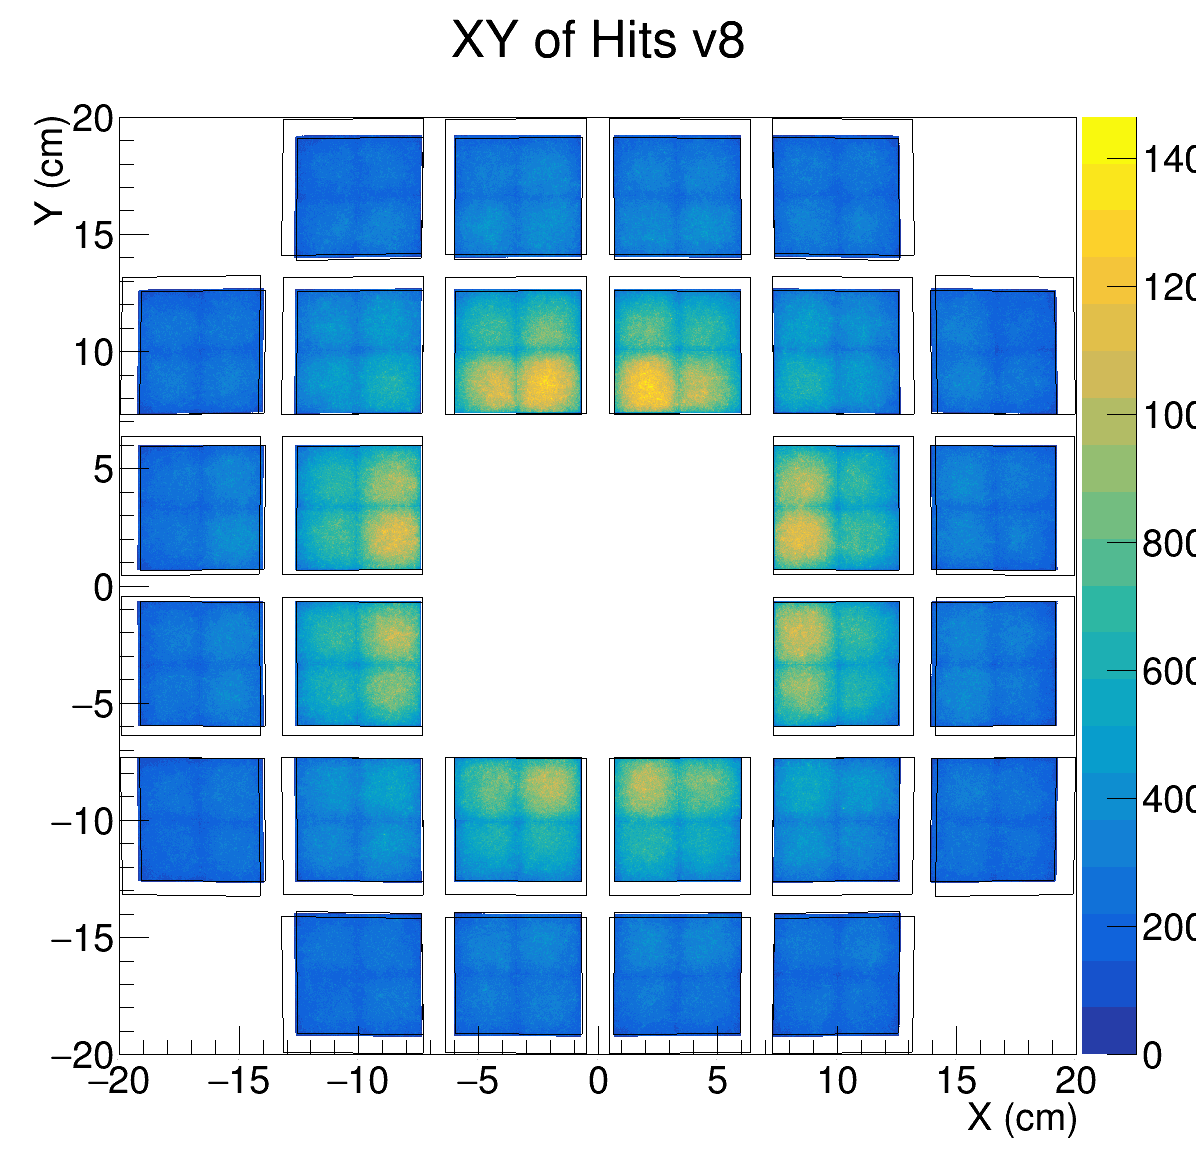

In [9]:
Rx = lambda ang: np.array([[1,0,0],[0,np.cos(ang), -np.sin(ang)],[0,np.sin(ang),np.cos(ang)]])
Ry = lambda ang: np.array([[np.cos(ang),0,np.sin(ang)],[0,1,0],[-np.sin(ang),0,np.cos(ang)]])
Rz = lambda ang: np.array([[np.cos(ang), -np.sin(ang),0],[np.sin(ang),np.cos(ang),0],[0,0,1]])

boxes = True
def boxmaker2D( index, x, y, ea, title="XY of Hits"):
    c2= ROOT.TCanvas("c2","c2",1200,1200)
    hs = ROOT.THStack("hs", title)
    for i in index:
        hs.Add(hdist2Dlist[i])
    hs.Draw("colz nostack")
    hs.GetXaxis().SetTitle("X (cm)")
    hs.GetYaxis().SetTitle("Y (cm)")
    boxlistq = list(np.zeros(len(x)))
    boxlistm = list(np.zeros(len(x)))
    wq = 5.3/2.
    wm = 5.9/2.
    if boxes:
        for i, n in enumerate(x):
            aq = np.array([ wq, wq, -2.2])  #-2.2 for the z should place plane of hits on the surface of the mcp,  
            bq = np.array([ wq,-wq, -2.2])  #NOT the surface of the quartz radiator. The dimensions of the detector 
            cq = np.array([-wq,-wq, -2.2])  #modules as defined in the alifitv#.cxx looks to be 5.9 x 5.9 x 5 cm, 
            dq = np.array([-wq, wq, -2.2])  #with the quartz element being 5.296 x 5.296 x 2.2 cm and the mcp being
                                            #5.898 x 5.898 x 2.8 cm. 
            
            am = np.array([ wm, wm, .3])  
            bm = np.array([ wm,-wm, .3]) 
            cm = np.array([-wm,-wm, .3])
            dm = np.array([-wm, wm, .3])
            
            Z1 = Rz(ea[0][i])
            X2 = Rx(ea[1][i])
            Z2 = Rz(ea[2][i])
            
            #gamma
            aq = np.matmul(Z2,aq)
            bq = np.matmul(Z2,bq)
            cq = np.matmul(Z2,cq)
            dq = np.matmul(Z2,dq)
            am = np.matmul(Z2,am)
            bm = np.matmul(Z2,bm)
            cm = np.matmul(Z2,cm)
            dm = np.matmul(Z2,dm)



            #beta
            aq = np.matmul(X2,aq)
            bq = np.matmul(X2,bq)
            cq = np.matmul(X2,cq)
            dq = np.matmul(X2,dq)
            am = np.matmul(X2,am)
            bm = np.matmul(X2,bm)
            cm = np.matmul(X2,cm)
            dm = np.matmul(X2,dm)



            #alpha
            aq = np.matmul(Z1,aq)
            bq = np.matmul(Z1,bq)
            cq = np.matmul(Z1,cq)
            dq = np.matmul(Z1,dq)
            am = np.matmul(Z1,am)
            bm = np.matmul(Z1,bm)
            cm = np.matmul(Z1,cm)
            dm = np.matmul(Z1,dm)
            

            boxlistq[i] = ROOT.TPolyLine(4)
            boxlistq[i].SetPoint(0, aq[0]+x[i], aq[1]+y[i])
            boxlistq[i].SetPoint(1, bq[0]+x[i], bq[1]+y[i])
            boxlistq[i].SetPoint(2, cq[0]+x[i], cq[1]+y[i])
            boxlistq[i].SetPoint(3, dq[0]+x[i], dq[1]+y[i])
            boxlistq[i].SetPoint(4, aq[0]+x[i], aq[1]+y[i])
            boxlistq[i].Draw()
            boxlistm[i] = ROOT.TPolyLine(4)
            boxlistm[i].SetPoint(0, am[0]+x[i], am[1]+y[i])
            boxlistm[i].SetPoint(1, bm[0]+x[i], bm[1]+y[i])
            boxlistm[i].SetPoint(2, cm[0]+x[i], cm[1]+y[i])
            boxlistm[i].SetPoint(3, dm[0]+x[i], dm[1]+y[i])
            boxlistm[i].SetPoint(4, am[0]+x[i], am[1]+y[i])
            boxlistm[i].Draw("same")
            
    c2.Draw()
r = 82
s = 3.31735114408*2
a, b, g, x, y, z = conc(r, s)

ea = [np.pi/180*a, np.pi/180*b, np.pi/180*g]
boxmaker2D([4],x, y, ea, title="XY of Hits v8")

## v4 XY Hits Histogram

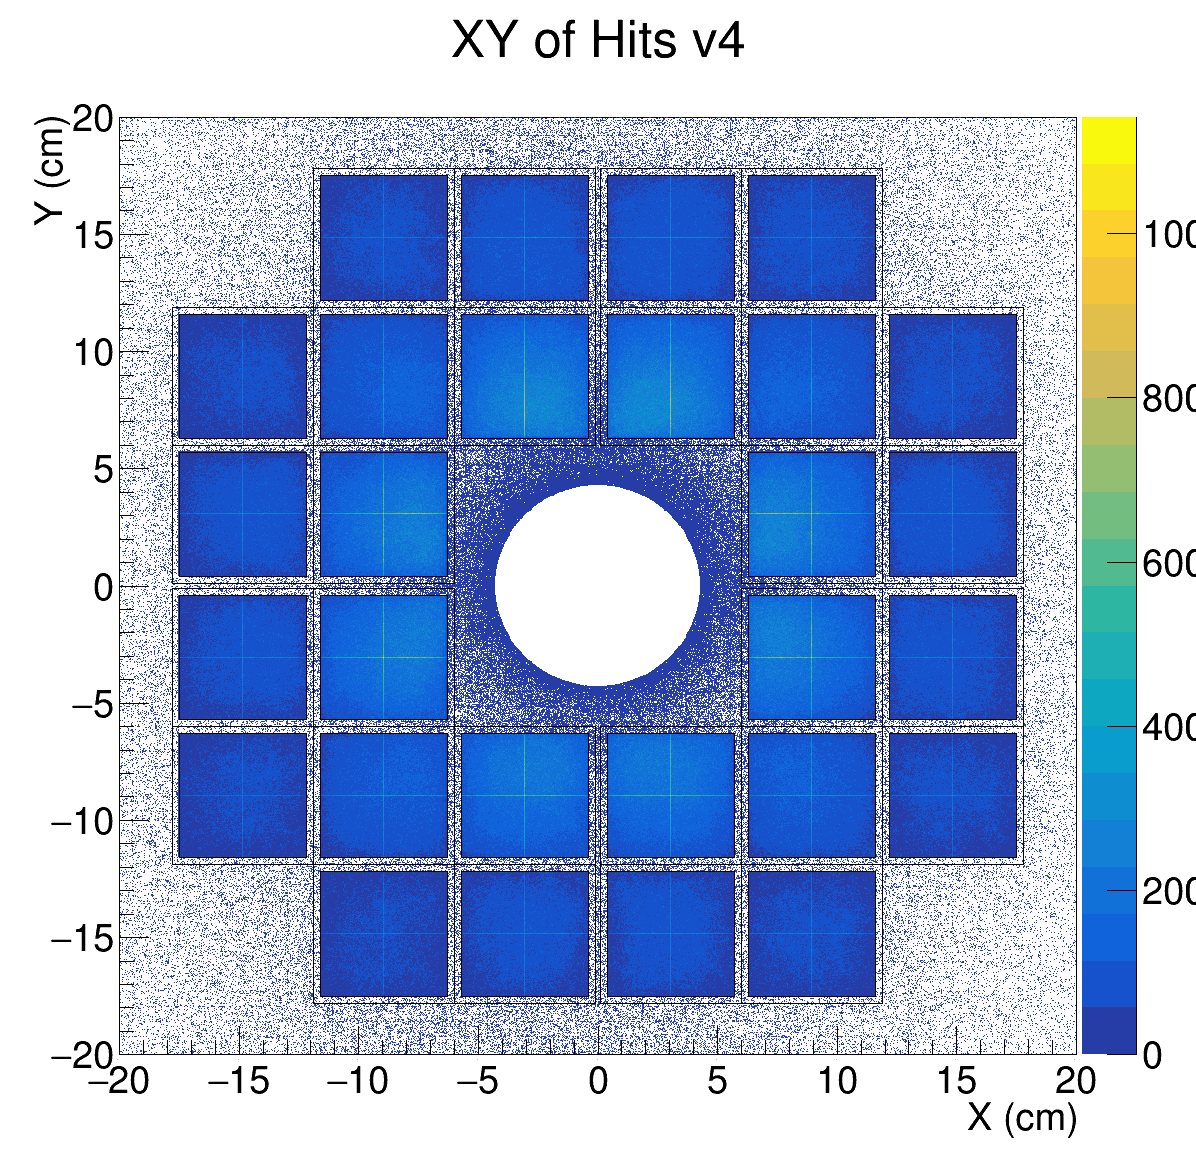

In [10]:
xc = np.array([-8.95, -3.05, 3.05, 8.95, 
                  -14.85, -8.95, -3.05, 3.05,
                  8.95,  14.85,-14.85, -8.95, 
                  8.95, 14.85, -14.85, -8.95, 
                  8.95, 14.85, -14.85,-8.95,
                  -3.05, 3.05, 8.95, 14.85, 
                  -8.95, -3.05, 3.05, 8.95])
yc = np.array([14.85, 14.85,14.85,14.85,
                  8.95,8.95,8.95,8.95,8.95,8.95,
                  3.05, 3.05,3.05,3.05,
                  -3.05,-3.05,-3.05,-3.05,
                  -8.95,-8.95,-8.95,-8.95,-8.95,-8.95,
                  -14.85,-14.85,-14.85,-14.85])
zc = np.ones(28)*r
r = 80
s = 5.9 
a, b, g, x, y, z = conc(r, s)

boxmaker2D([0],xc, yc, [np.zeros(28),np.zeros(28),np.zeros(28)], title="XY of Hits v4")

Loading PDG code histograms 

In [19]:
hpdgcode4 = f4.Get("v4hpdgcode")
hpdgcode5 = f5.Get("v5hpdgcode")
hpdgcode6 = f6.Get("v6hpdgcode")
hpdgcode7 = f7.Get("v7hpdgcode")
hpdgcode8 = f8.Get("v8hpdgcode")

## PDG Codes Histogram

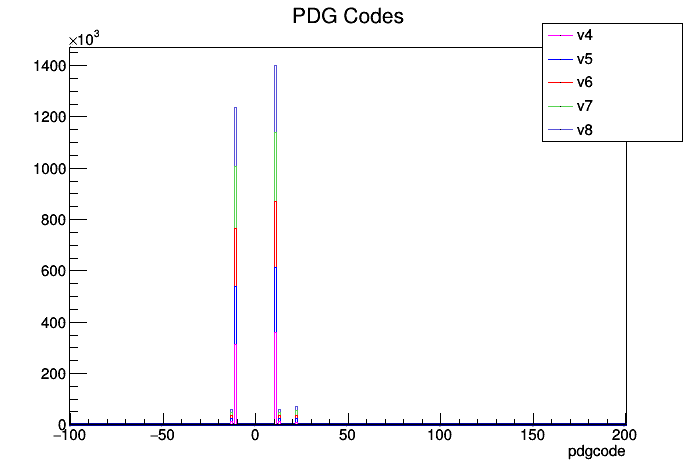

In [20]:
c5 = ROOT.TCanvas()

hs = ROOT.THStack("hs", "PDG Codes")

hpdgcode4.SetLineColorAlpha(6, 1)
hs.Add(hpdgcode4)

hpdgcode5.SetLineColorAlpha(4, 1)
hs.Add(hpdgcode5)

hpdgcode6.SetLineColorAlpha(2, 1)
hs.Add(hpdgcode6)

hpdgcode7.SetLineColorAlpha(8, 1)
hs.Add(hpdgcode7)

hpdgcode8.SetLineColorAlpha(9, 1)
hs.Add(hpdgcode8)


hs.Draw()
hs.GetXaxis().SetRangeUser(-100,200)
hs.GetXaxis().SetTitle("pdgcode")
c5.BuildLegend(0.78,0.7,0.98, 0.95)
c5.SetPhi(0)
c5.SetTheta(0)
c5.Draw()

Loading time of flight \( TOF \) vs Micro Channel Plate Number \( MCP \) 2D histograms

In [21]:
htof4 = f4.Get("v4htof")
htof5 = f5.Get("v5htof")
htof6 = f6.Get("v6htof")
htof7 = f7.Get("v7htof")
htof8 = f8.Get("v8htof")

## TOF v MCP 2D Histograms

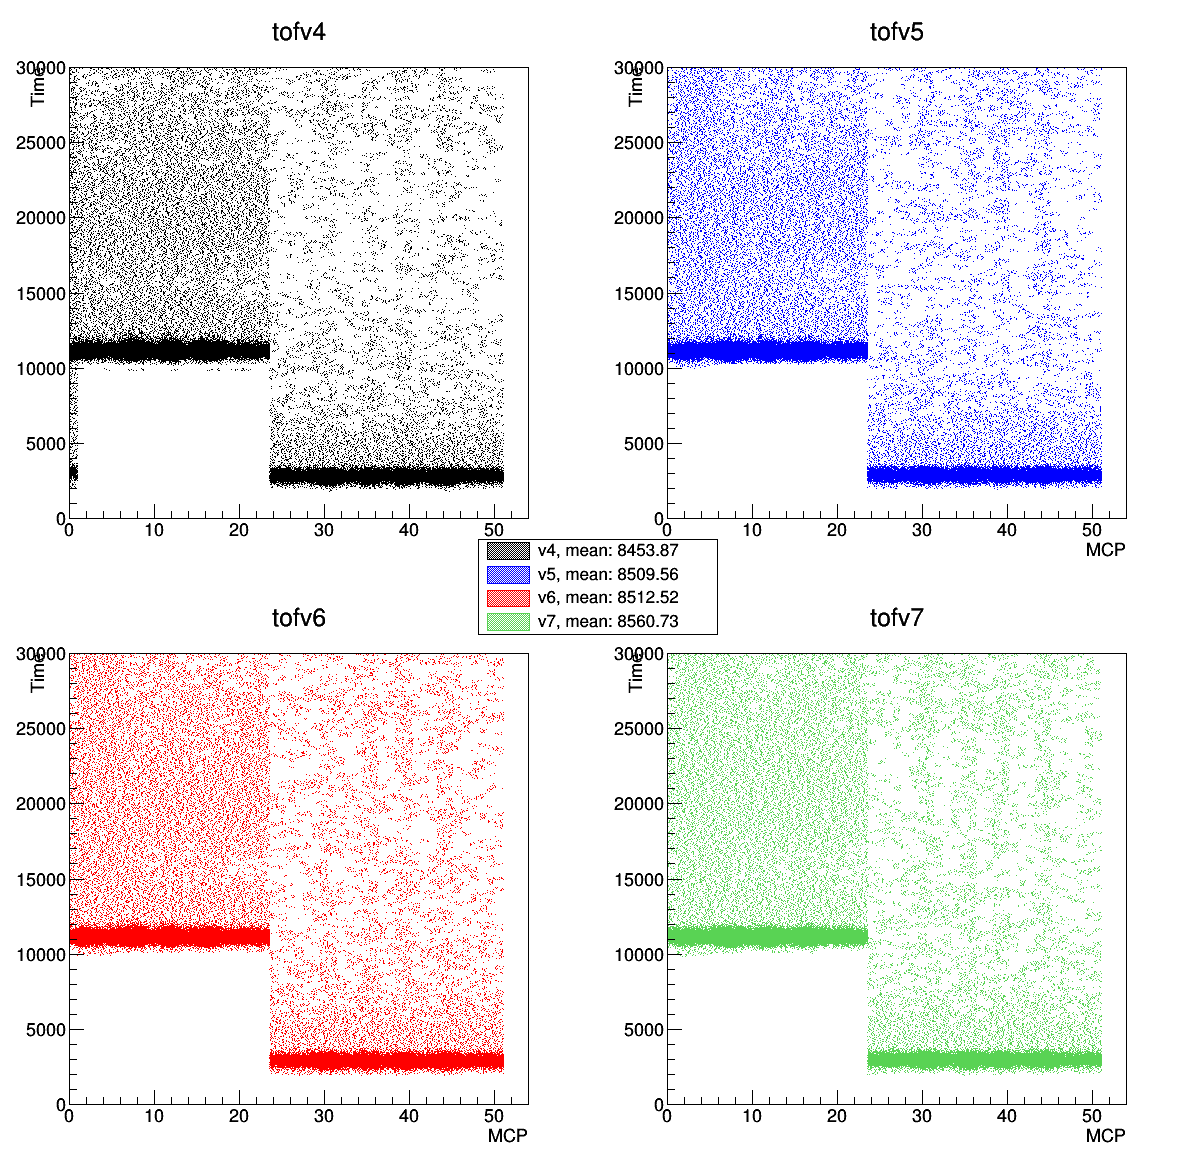

In [22]:
c6 = ROOT.TCanvas("c6","c6",1200,1200)
c6.Divide(2,2)
xmin = 0
xmax = 6500

htof4.GetXaxis().SetRangeUser(xmin, xmax)
htof4.SetLineColorAlpha(1, 1)
htof4.SetMarkerColorAlpha(1, 1)
htof4.SetFillColor(1)
htof4.SetFillStyle(3001)

htof5.GetXaxis().SetRangeUser(xmin, xmax)
htof5.SetLineColorAlpha(4, 1)
htof5.SetMarkerColorAlpha(4, 1)
htof5.SetFillColor(4)
htof5.SetFillStyle(3001)

htof6.GetXaxis().SetRangeUser(xmin, xmax)
htof6.SetLineColorAlpha(2, 1)
htof6.SetMarkerColorAlpha(2, 1)
htof6.SetFillColor(2)
htof6.SetFillStyle(3001)

htof7.GetXaxis().SetRangeUser(xmin, xmax)
htof7.SetLineColorAlpha(8, 1)
htof7.SetMarkerColorAlpha(8, 1)
htof7.SetFillColor(8)
htof7.SetFillStyle(3001)


c6.cd(1)
htof4.Draw()
c6.cd(2)
htof5.Draw()
c6.cd(3)
htof6.Draw()
c6.cd(4)
htof7.Draw()


c6.cd(0)
legend = ROOT.TLegend(0.40,0.459,0.60, 0.54)
#legend.SetHeader("The Legend Title")
legend.AddEntry(htof4,"v4, mean: %7.2f" % (htof4.GetMean(2)),"f")
legend.AddEntry(htof5,"v5, mean: %7.2f" % (htof5.GetMean(2)),"f")
legend.AddEntry(htof6,"v6, mean: %7.2f" % (htof6.GetMean(2)),"f")
legend.AddEntry(htof7,"v7, mean: %7.2f" % (htof7.GetMean(2)),"f")
legend.Draw()

c6.Draw()

Loading distance traveled for hits histograms

In [23]:
hdist4 = f4.Get("v4hdist")
hdist5 = f5.Get("v5hdist")
hdist6 = f6.Get("v6hdist")
hdist7 = f7.Get("v7hdist")
hdist8 = f8.Get("v8hdist")

## Distance Traveled for Hits Histograms

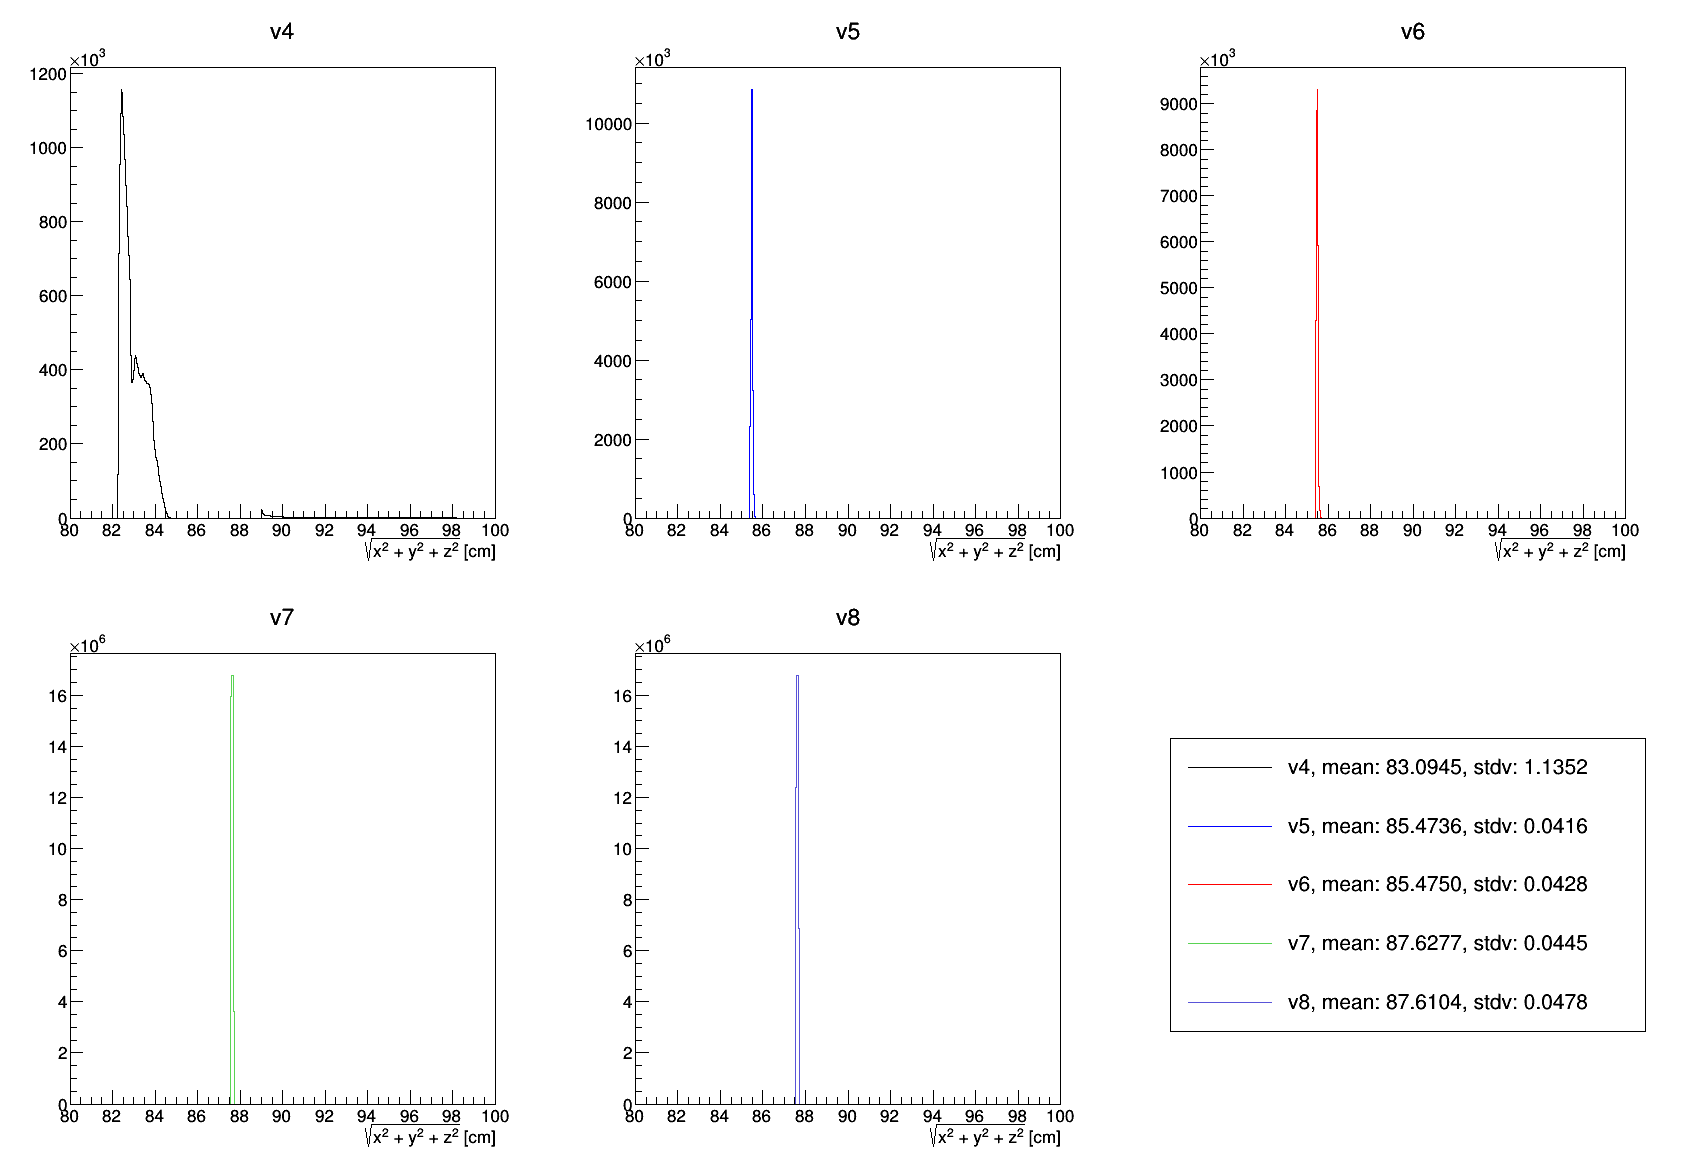

In [24]:
c7 = ROOT.TCanvas("c7","c7", 1700,1200)

c7.Divide(3,2)

xmin = 80
xmax = 100

hdist4.GetXaxis().SetRangeUser(xmin, xmax)
hdist4.SetLineColorAlpha(1, 1)

hdist5.GetXaxis().SetRangeUser(xmin, xmax)
hdist5.SetLineColorAlpha(4, 1)

hdist6.GetXaxis().SetRangeUser(xmin, xmax)
hdist6.SetLineColorAlpha(2, 1)

hdist7.GetXaxis().SetRangeUser(xmin, xmax)
hdist7.SetLineColorAlpha(8, 1)

hdist8.GetXaxis().SetRangeUser(xmin, xmax)
hdist8.SetLineColorAlpha(9, 1)

log = False
p1 = c7.cd(1)
if log:
    p1.SetLogy()
hdist4.Draw()

p2 = c7.cd(2)
if log:
    p2.SetLogy()
hdist5.Draw()

p3 = c7.cd(3)
if log:
    p3.SetLogy()
hdist6.Draw()

p4 = c7.cd(4)
if log:
    p4.SetLogy()
hdist7.Draw()

p5 = c7.cd(5)
if log:
    p5.SetLogy()
hdist8.Draw()

c7.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
#legend.SetHeader("The Legend Title")
legend.AddEntry(hdist4,"v4, mean: %7.4f, stdv: %5.4f" % (hdist4.GetMean(), hdist4.GetStdDev()),"l")
legend.AddEntry(hdist5,"v5, mean: %7.4f, stdv: %5.4f" % (hdist5.GetMean(), hdist5.GetStdDev()),"l")
legend.AddEntry(hdist6,"v6, mean: %7.4f, stdv: %5.4f" % (hdist6.GetMean(), hdist6.GetStdDev()),"l")
legend.AddEntry(hdist7,"v7, mean: %7.4f, stdv: %5.4f" % (hdist7.GetMean(), hdist7.GetStdDev()),"l")
legend.AddEntry(hdist8,"v8, mean: %7.4f, stdv: %5.4f" % (hdist8.GetMean(), hdist8.GetStdDev()),"l")
legend.Draw()

c7.Draw()

Loading XYZ Hits Histograms

In [25]:
hits3d4 = f4.Get("v4hits3d")
hits3d5 = f5.Get("v5hits3d")
hits3d6 = f6.Get("v6hits3d")
hits3d7 = f7.Get("v7hits3d")
hits3d8 = f8.Get("v8hits3d")

In [26]:
def hits3d(Theta=45,Phi=45):
    c8 = ROOT.TCanvas("c8","c8",1500,1200)
    c8.Divide(3,2)
    xmin = 0
    xmax = 6500

    hits3d4.GetXaxis().SetRangeUser(xmin, xmax)
    hits3d4.SetLineColorAlpha(1, 1)
    hits3d4.SetMarkerColorAlpha(1, 1)
    hits3d4.SetFillColor(1)
    hits3d4.SetFillStyle(3001)

    hits3d5.GetXaxis().SetRangeUser(xmin, xmax)
    hits3d5.SetLineColorAlpha(4, 1)
    hits3d5.SetMarkerColorAlpha(4, 1)
    hits3d5.SetFillColor(4)
    hits3d5.SetFillStyle(3001)

    hits3d6.GetXaxis().SetRangeUser(xmin, xmax)
    hits3d6.SetLineColorAlpha(2, 1)
    hits3d6.SetMarkerColorAlpha(2, 1)
    hits3d6.SetFillColor(2)
    hits3d6.SetFillStyle(3001)

    hits3d7.GetXaxis().SetRangeUser(xmin, xmax)
    hits3d7.SetLineColorAlpha(8, 1)
    hits3d7.SetMarkerColorAlpha(8, 1)
    hits3d7.SetFillColor(8)
    hits3d7.SetFillStyle(3001)
    
    hits3d8.GetXaxis().SetRangeUser(xmin, xmax)
    hits3d8.SetLineColorAlpha(9, 1)
    hits3d8.SetMarkerColorAlpha(9, 1)
    hits3d8.SetFillColor(9)
    hits3d8.SetFillStyle(3001)


    c8.cd(1)
    hits3d4.Draw()
    c8.GetPad(1).SetPhi(Phi)
    c8.GetPad(1).SetTheta(Theta)
    
    c8.cd(2)
    hits3d5.Draw()
    c8.GetPad(2).SetPhi(Phi)
    c8.GetPad(2).SetTheta(Theta)
    
    c8.cd(3)
    hits3d6.Draw()
    c8.GetPad(3).SetPhi(Phi)
    c8.GetPad(3).SetTheta(Theta)
    
    c8.cd(4)
    hits3d7.Draw()
    c8.GetPad(4).SetPhi(Phi)
    c8.GetPad(4).SetTheta(Theta)
    
    c8.cd(5)
    hits3d8.Draw()
    c8.GetPad(5).SetPhi(Phi)
    c8.GetPad(5).SetTheta(Theta)


    c8.cd(0)
    legend = ROOT.TLegend(0.7,0.35,.97, 0.1)
    #legend.SetHeader("The Legend Title")
    legend.AddEntry(hits3d4,"v4, mean: %7.2f, stdv: %5.2f" % (hits3d4.GetMean(1), hits3d4.GetStdDev(1)),"f")
    legend.AddEntry(hits3d5,"v5, mean: %7.2f, stdv: %5.2f" % (hits3d5.GetMean(1), hits3d5.GetStdDev(1)),"f")
    legend.AddEntry(hits3d6,"v6, mean: %7.2f, stdv: %5.2f" % (hits3d6.GetMean(1), hits3d6.GetStdDev(1)),"f")
    legend.AddEntry(hits3d7,"v7, mean: %7.2f, stdv: %5.2f" % (hits3d7.GetMean(1), hits3d7.GetStdDev(1)),"f")
    legend.AddEntry(hits3d8,"v8, mean: %7.2f, stdv: %5.2f" % (hits3d8.GetMean(1), hits3d8.GetStdDev(1)),"f")
    legend.Draw()

    c8.Draw()

## XYZ Hits

In [27]:
interact(hits3d,Theta=(0,90,1),Phi=(0,90,1))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.hits3d>

[IPKernelApp] WARNING | Widget Javascript not detected.  It may not be installed or enabled properly.


Loading histogram stacks of the Number of Primaries histogram and the Tracks Hit Histograms

In [29]:
v4hs2 = f4.Get("hs2")
v5hs2 = f5.Get("hs2")
v6hs2 = f6.Get("hs2")
v7hs2 = f7.Get("hs2")
v8hs2 = f8.Get("hs2")

v4nprim = f4.Get("v4nPrim")
v5nprim = f5.Get("v5nPrim")
v6nprim = f6.Get("v6nPrim")
v7nprim = f7.Get("v7nPrim")
v8nprim = f8.Get("v8nPrim")

v4tracksh = f4.Get("v4TracksH")
v5tracksh = f5.Get("v5TracksH")
v6tracksh = f6.Get("v6TracksH")
v7tracksh = f7.Get("v7TracksH")
v8tracksh = f8.Get("v8TracksH")

## nPrimaries vs. TracksH

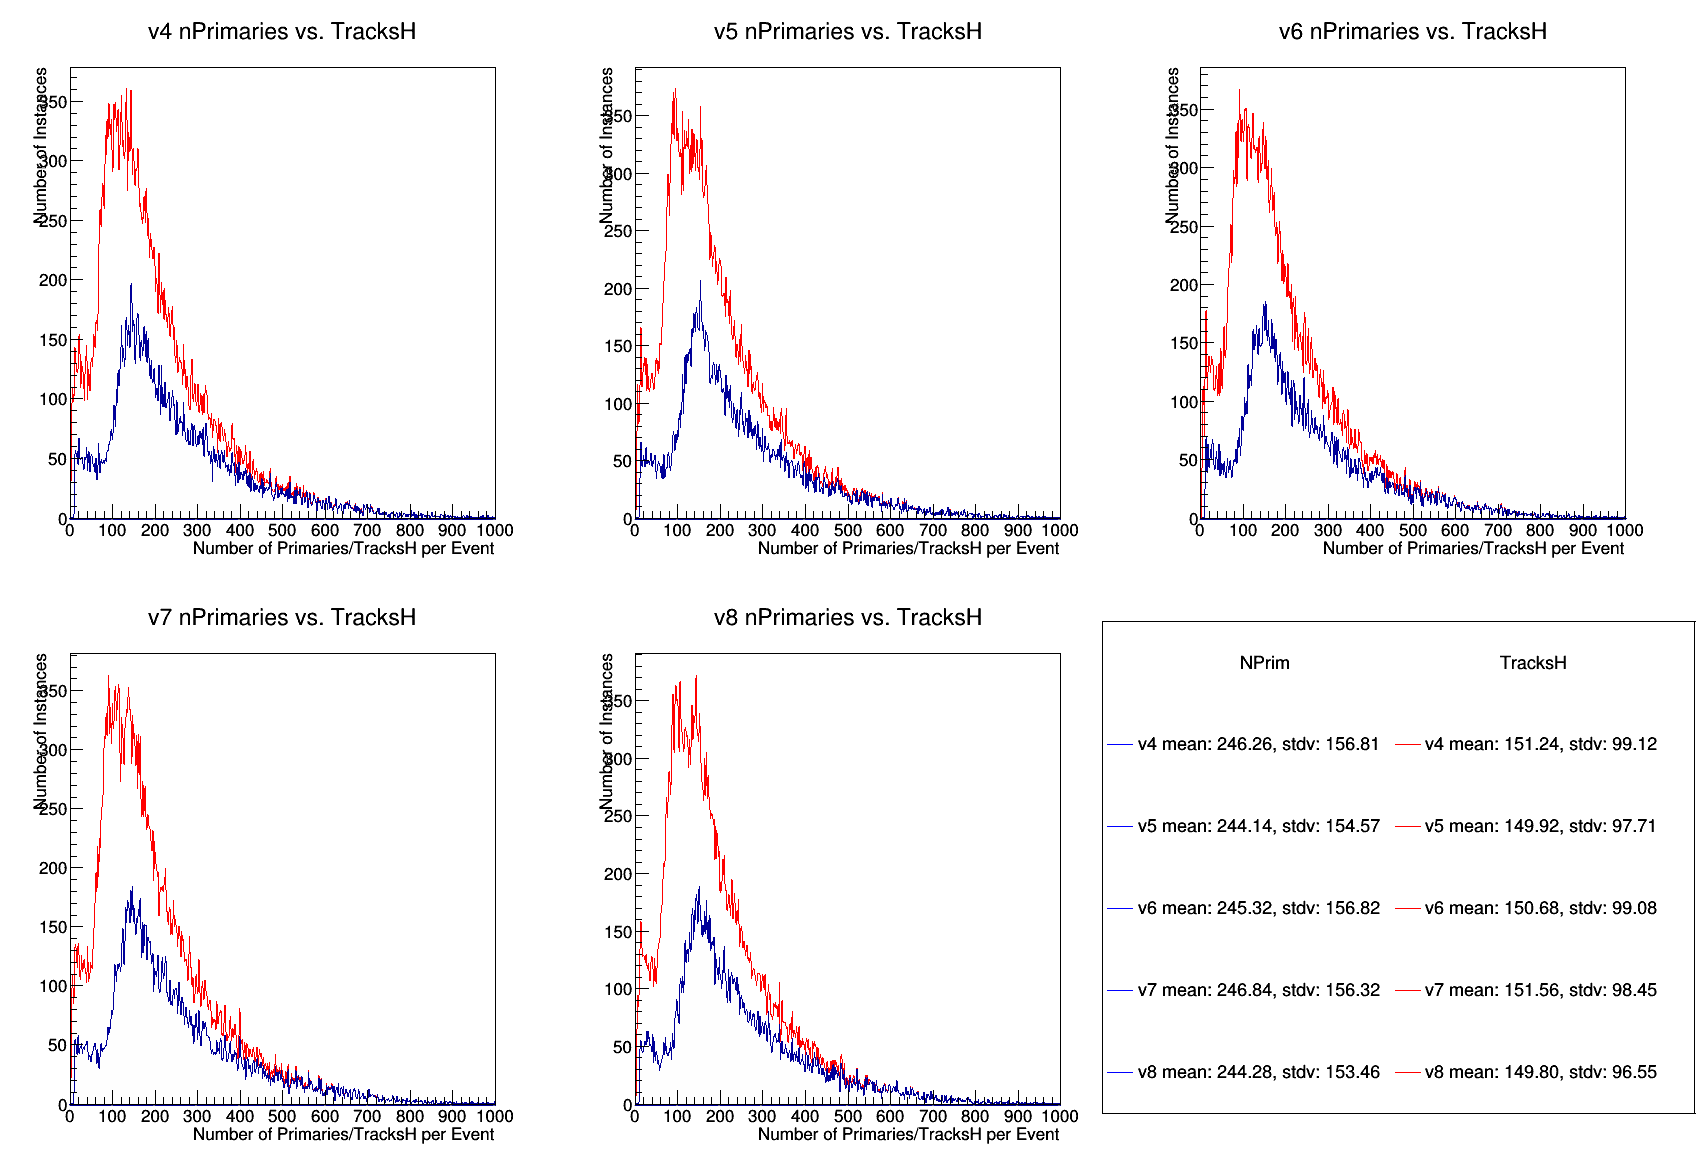

In [30]:
c9 = ROOT.TCanvas("c9","c9",1700,1200)
c9.Divide(3,2)
xmin = 0
xmax = 1000
ymin = 0
ymax = 10


v4nprim.SetLineColorAlpha(4, 1)
v5nprim.SetLineColorAlpha(4, 1)
v6nprim.SetLineColorAlpha(4, 1)
v7nprim.SetLineColorAlpha(4, 1)
v8nprim.SetLineColorAlpha(4, 1)

v4tracksh.SetLineColorAlpha(2, 1)
v5tracksh.SetLineColorAlpha(2, 1)
v6tracksh.SetLineColorAlpha(2, 1)
v7tracksh.SetLineColorAlpha(2, 1)
v8tracksh.SetLineColorAlpha(2, 1)


c9.cd(1)
v4hs2.Draw()
v4hs2.GetXaxis().SetTitle("Number of Primaries/TracksH per Event")
v4hs2.GetYaxis().SetTitle("Number of Instances")

c9.cd(2)
v5hs2.Draw()
v5hs2.GetXaxis().SetTitle("Number of Primaries/TracksH per Event")
v5hs2.GetYaxis().SetTitle("Number of Instances")

c9.cd(3)
v6hs2.Draw()
v6hs2.GetXaxis().SetTitle("Number of Primaries/TracksH per Event")
v6hs2.GetYaxis().SetTitle("Number of Instances")

c9.cd(4)
v7hs2.Draw()
v7hs2.GetXaxis().SetTitle("Number of Primaries/TracksH per Event")
v7hs2.GetYaxis().SetTitle("Number of Instances")

c9.cd(5)
v8hs2.Draw()
v8hs2.GetXaxis().SetTitle("Number of Primaries/TracksH per Event")
v8hs2.GetYaxis().SetTitle("Number of Instances")

c9.cd(0)
legend = ROOT.TLegend(0.65,0.47,1, 0.05)
legend.SetHeader("                           NPrim                                          TracksH")
legend.SetNColumns(2)
legend.SetMargin(0.12)
legend.SetEntrySeparation(0)
legend.SetColumnSeparation(-.05)
legend.AddEntry(v4nprim,  "v4 mean: %5.2f, stdv: %5.2f" % (v4nprim.GetMean(1), v4nprim.GetStdDev(1)),"l")
legend.AddEntry(v4tracksh,"v4 mean: %5.2f, stdv: %5.2f" % (v4tracksh.GetMean(1), v4tracksh.GetStdDev(1)),"l")
legend.AddEntry(v5nprim,  "v5 mean: %5.2f, stdv: %5.2f" % (v5nprim.GetMean(1), v5nprim.GetStdDev(1)),"l")
legend.AddEntry(v5tracksh,"v5 mean: %5.2f, stdv: %5.2f" % (v5tracksh.GetMean(1), v5tracksh.GetStdDev(1)),"l")
legend.AddEntry(v6nprim,  "v6 mean: %5.2f, stdv: %5.2f" % (v6nprim.GetMean(1), v6nprim.GetStdDev(1)),"l")
legend.AddEntry(v6tracksh,"v6 mean: %5.2f, stdv: %5.2f" % (v6tracksh.GetMean(1), v6tracksh.GetStdDev(1)),"l")
legend.AddEntry(v7nprim,  "v7 mean: %5.2f, stdv: %5.2f" % (v7nprim.GetMean(1), v7nprim.GetStdDev(1)),"l")
legend.AddEntry(v7tracksh,"v7 mean: %5.2f, stdv: %5.2f" % (v7tracksh.GetMean(1), v7tracksh.GetStdDev(1)),"l")
legend.AddEntry(v8nprim,  "v8 mean: %5.2f, stdv: %5.2f" % (v8nprim.GetMean(1), v8nprim.GetStdDev(1)),"l")
legend.AddEntry(v8tracksh,"v8 mean: %5.2f, stdv: %5.2f" % (v8tracksh.GetMean(1), v8tracksh.GetStdDev(1)),"l")
legend.Draw()

c9.Draw()

Loading intial primary kinematics \( Transverse Momentum vs. $\eta$ \) 2D histograms

In [31]:
kPtEta4 = f4.Get("v4kPtEta")
kPtEta5 = f5.Get("v5kPtEta")
kPtEta6 = f6.Get("v6kPtEta")
kPtEta7 = f7.Get("v7kPtEta")
kPtEta8 = f8.Get("v8kPtEta")

## Generated Primary $P_t$  vs   $\eta $ for Expected Hit $\eta$ Ranges

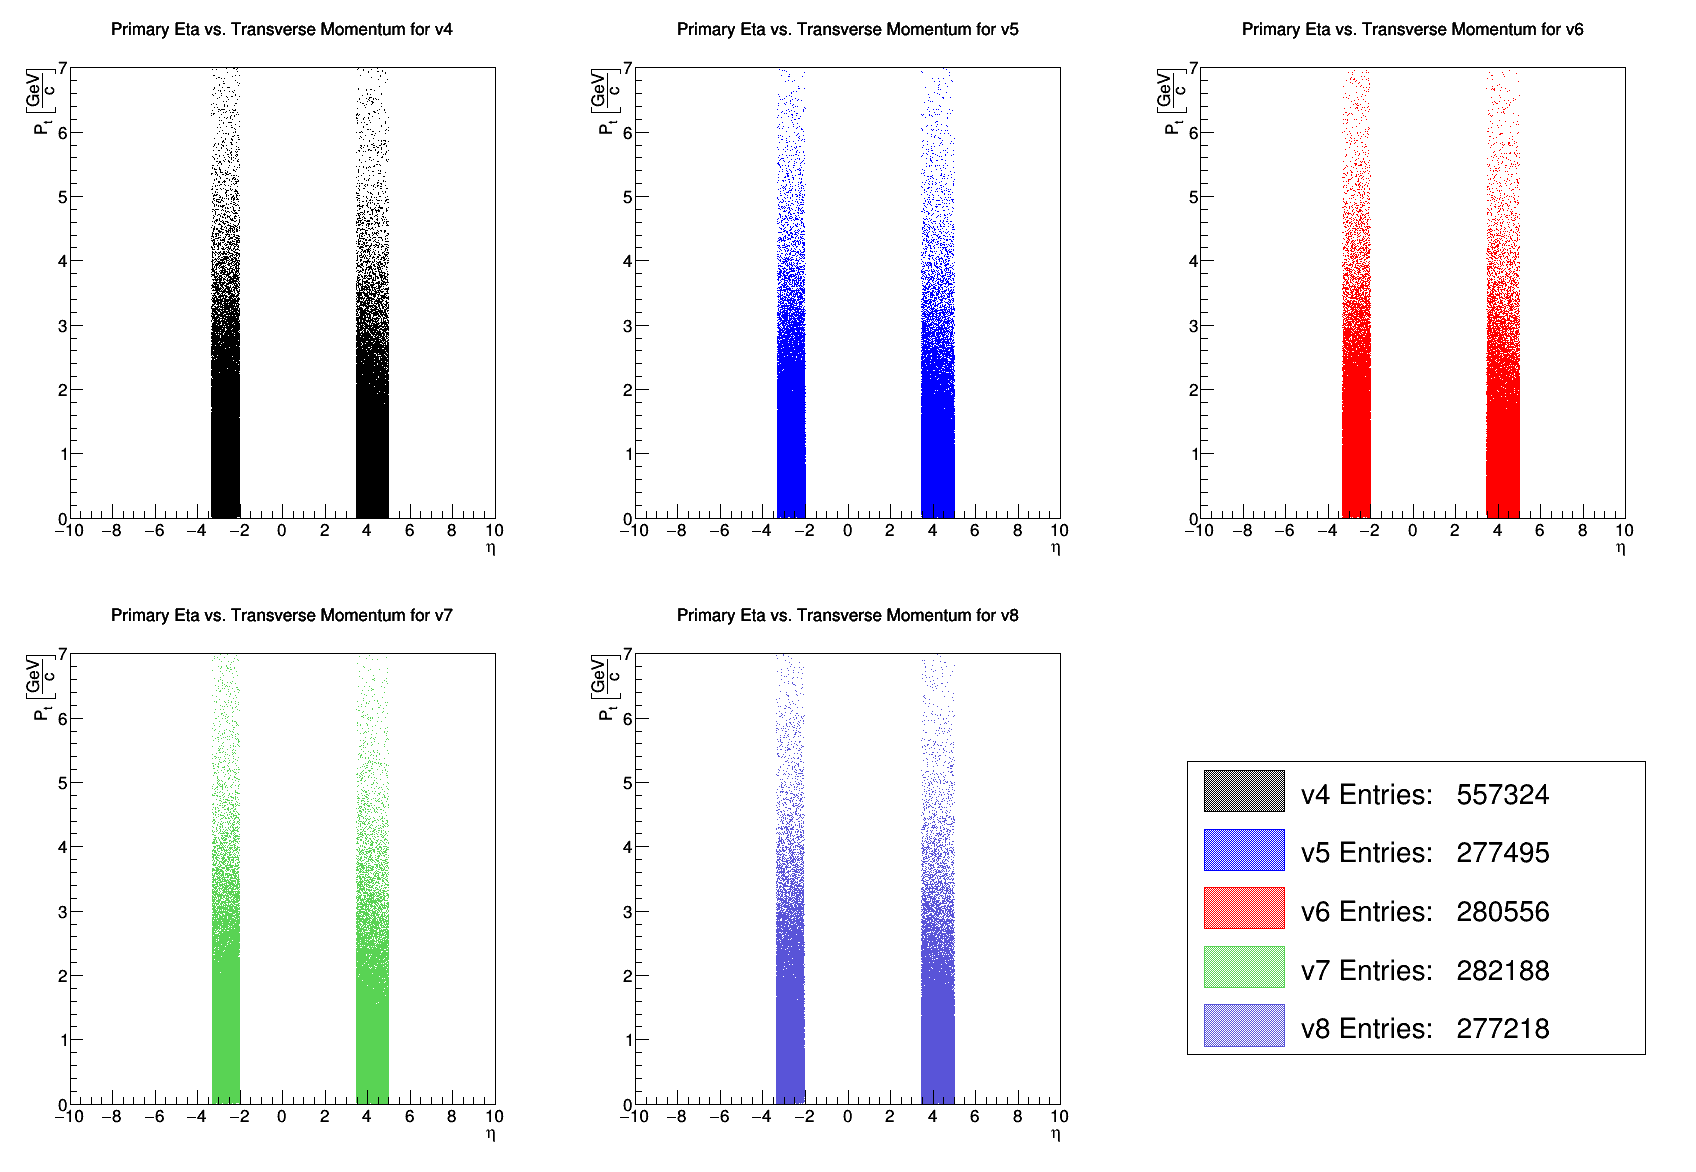

In [32]:
c10 = ROOT.TCanvas("c10","c10",1700,1200)
c10.Divide(3,2)
xmin = -10
xmax = 10
ymin = 0
ymax = 7

kPtEta4.GetXaxis().SetRangeUser(xmin, xmax)
kPtEta4.GetYaxis().SetRangeUser(ymin, ymax)
kPtEta4.SetLineColorAlpha(1, 1)
kPtEta4.SetMarkerColorAlpha(1, 1)
kPtEta4.SetFillColor(1)
kPtEta4.SetFillStyle(3001)

kPtEta5.GetXaxis().SetRangeUser(xmin, xmax)
kPtEta5.GetYaxis().SetRangeUser(ymin, ymax)
kPtEta5.SetLineColorAlpha(4, 1)
kPtEta5.SetMarkerColorAlpha(4, 1)
kPtEta5.SetFillColor(4)
kPtEta5.SetFillStyle(3001)

kPtEta6.GetXaxis().SetRangeUser(xmin, xmax)
kPtEta6.GetYaxis().SetRangeUser(ymin, ymax)
kPtEta6.SetLineColorAlpha(2, 1)
kPtEta6.SetMarkerColorAlpha(2, 1)
kPtEta6.SetFillColor(2)
kPtEta6.SetFillStyle(3001)

kPtEta7.GetXaxis().SetRangeUser(xmin, xmax)
kPtEta7.GetYaxis().SetRangeUser(ymin, ymax)
kPtEta7.SetLineColorAlpha(8, 1)
kPtEta7.SetMarkerColorAlpha(8, 1)
kPtEta7.SetFillColor(8)
kPtEta7.SetFillStyle(3001)

kPtEta8.GetXaxis().SetRangeUser(xmin, xmax)
kPtEta8.GetYaxis().SetRangeUser(ymin, ymax)
kPtEta8.SetLineColorAlpha(9, 1)
kPtEta8.SetMarkerColorAlpha(9, 1)
kPtEta8.SetFillColor(9)
kPtEta8.SetFillStyle(3001)


c10.cd(1)
kPtEta4.Draw()

c10.cd(2)
kPtEta5.Draw()

c10.cd(3)
kPtEta6.Draw()

c10.cd(4)
kPtEta7.Draw()

c10.cd(5)
kPtEta8.Draw()

c10.cd(0)
legend = ROOT.TLegend(0.7,0.35,.97, 0.1)
#legend.SetHeader("The Legend Title")
legend.AddEntry(kPtEta4,"v4 Entries: %8d" % (kPtEta4.GetEntries()),"f")
legend.AddEntry(kPtEta5,"v5 Entries: %8d" % (kPtEta5.GetEntries()),"f")
legend.AddEntry(kPtEta6,"v6 Entries: %8d" % (kPtEta6.GetEntries()),"f")
legend.AddEntry(kPtEta7,"v7 Entries: %8d" % (kPtEta7.GetEntries()),"f")
legend.AddEntry(kPtEta8,"v8 Entries: %8d" % (kPtEta8.GetEntries()),"f")
legend.Draw()

c10.Draw()

Loading hit primary kinematics 2D histograms

In [33]:
PtEta4 = f4.Get("v4PtEta")
PtEta5 = f5.Get("v5PtEta")
PtEta6 = f6.Get("v6PtEta")
PtEta7 = f7.Get("v7PtEta")
PtEta8 = f8.Get("v8PtEta")

## Hit Primary $P_t$  vs   $\eta $

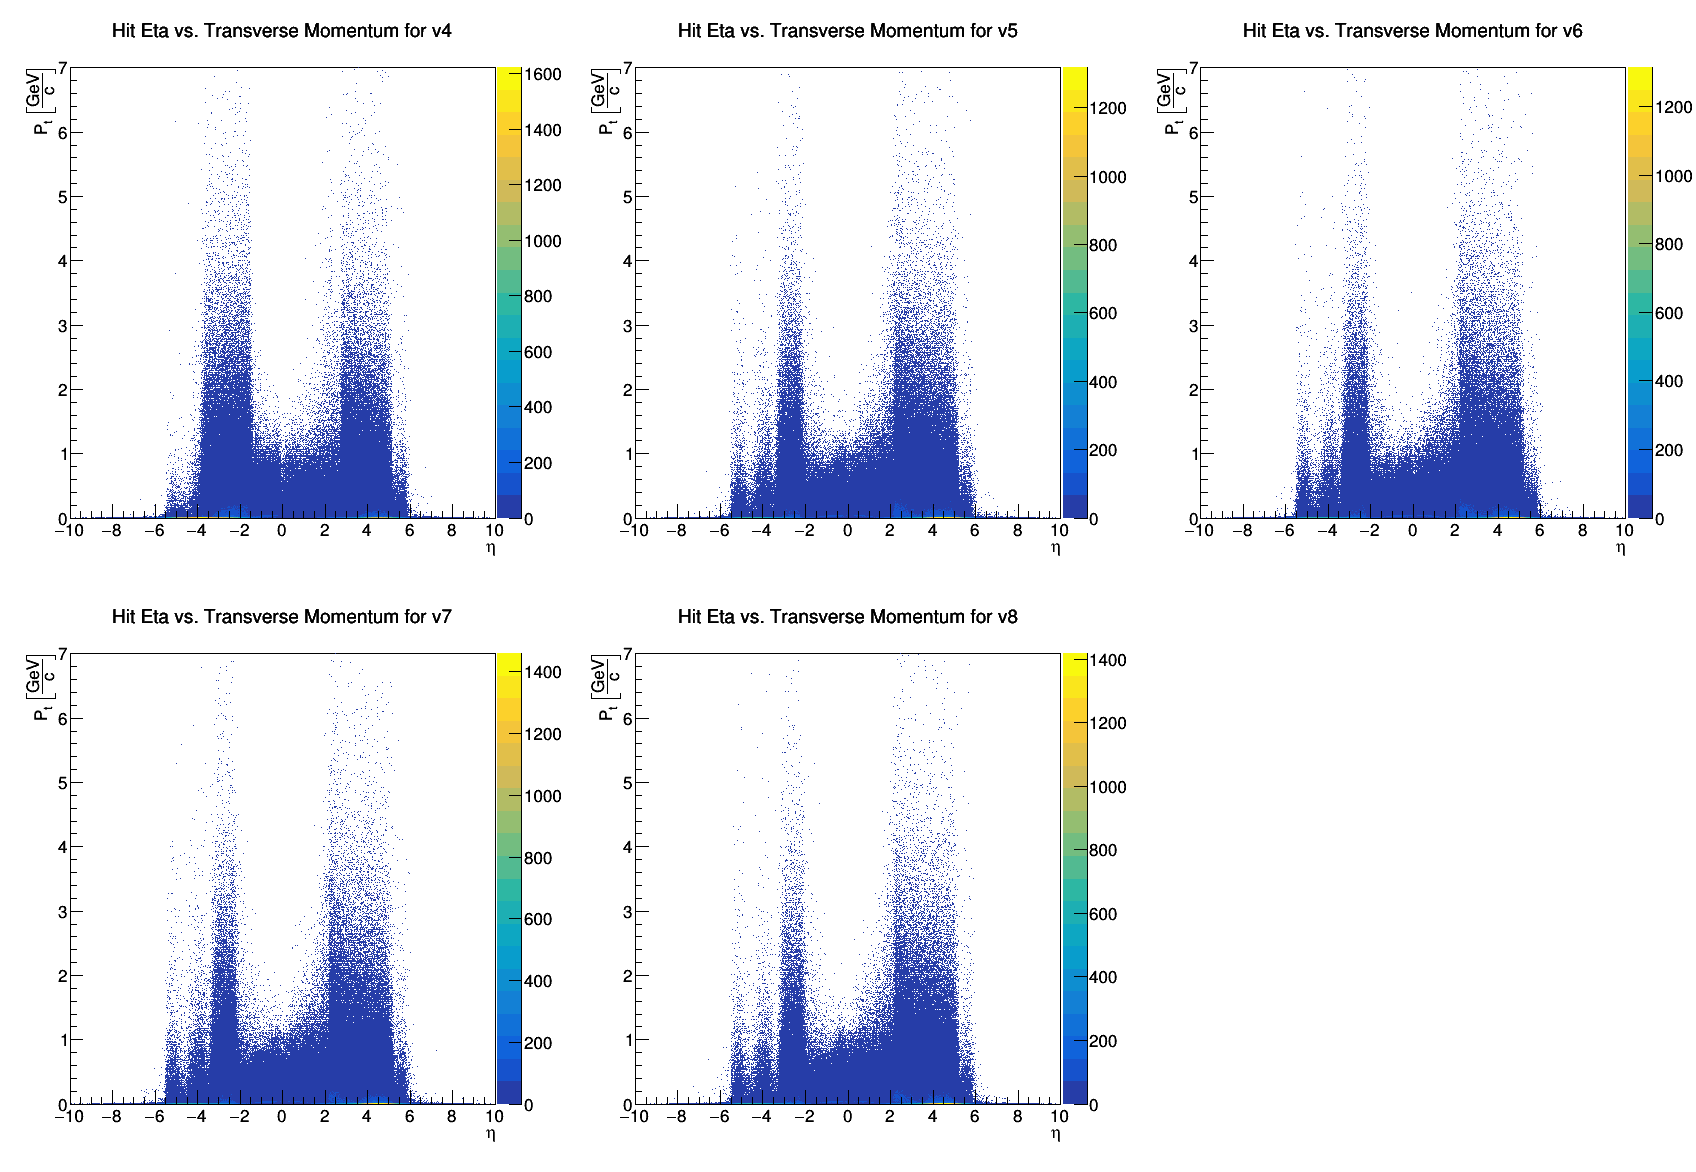

In [34]:
c11 = ROOT.TCanvas("c11","c11",1700,1200)
c11.Divide(3,2)
xmin = -10
xmax = 10
ymin = 0
ymax = 7

PtEta4.GetXaxis().SetRangeUser(xmin, xmax)
PtEta4.GetYaxis().SetRangeUser(ymin, ymax)
PtEta4.SetLineColorAlpha(1, 1)
PtEta4.SetMarkerColorAlpha(1, 1)
PtEta4.SetFillColor(1)
PtEta4.SetFillStyle(3001)

PtEta5.GetXaxis().SetRangeUser(xmin, xmax)
PtEta5.GetYaxis().SetRangeUser(ymin, ymax)
PtEta5.SetLineColorAlpha(4, 1)
PtEta5.SetMarkerColorAlpha(4, 1)
PtEta5.SetFillColor(4)
PtEta5.SetFillStyle(3001)

PtEta6.GetXaxis().SetRangeUser(xmin, xmax)
PtEta6.GetYaxis().SetRangeUser(ymin, ymax)
PtEta6.SetLineColorAlpha(2, 1)
PtEta6.SetMarkerColorAlpha(2, 1)
PtEta6.SetFillColor(2)
PtEta6.SetFillStyle(3001)

PtEta7.GetXaxis().SetRangeUser(xmin, xmax)
PtEta7.GetYaxis().SetRangeUser(ymin, ymax)
PtEta7.SetLineColorAlpha(8, 1)
PtEta7.SetMarkerColorAlpha(8, 1)
PtEta7.SetFillColor(8)
PtEta7.SetFillStyle(3001)

PtEta8.GetXaxis().SetRangeUser(xmin, xmax)
PtEta8.GetYaxis().SetRangeUser(ymin, ymax)
PtEta8.SetLineColorAlpha(9, 1)
PtEta8.SetMarkerColorAlpha(9, 1)
PtEta8.SetFillColor(9)
PtEta8.SetFillStyle(3001)


c11.cd(1)
PtEta4.Draw("colz")

c11.cd(2)
PtEta5.Draw("colz")

c11.cd(3)
PtEta6.Draw("colz")

c11.cd(4)
PtEta7.Draw("colz")

c11.cd(5)
PtEta8.Draw("colz")

c11.cd(0)
legend = ROOT.TLegend(0.7,0.35,.97, 0.1)
#legend.SetHeader("The Legend Title")
legend.AddEntry(PtEta4,"v4, Pt mean: %5.2f, stdv: %5.2f" % (PtEta4.GetMean(2), PtEta4.GetStdDev(2)),"f")
legend.AddEntry(PtEta5,"v5, Pt mean: %5.2f, stdv: %5.2f" % (PtEta5.GetMean(2), PtEta5.GetStdDev(2)),"f")
legend.AddEntry(PtEta6,"v6, Pt mean: %5.2f, stdv: %5.2f" % (PtEta6.GetMean(2), PtEta6.GetStdDev(2)),"f")
legend.AddEntry(PtEta7,"v7, Pt mean: %5.2f, stdv: %5.2f" % (PtEta7.GetMean(2), PtEta7.GetStdDev(2)),"f")
legend.AddEntry(PtEta8,"v8, Pt mean: %5.2f, stdv: %5.2f" % (PtEta8.GetMean(2), PtEta8.GetStdDev(2)),"f")
#legend.Draw()

c11.Draw()

Loading hit primary kinematics 2D histograms for expected $\eta$ ranges

In [35]:
pPtEta4 = f4.Get("v4pPtEta")
pPtEta5 = f5.Get("v5pPtEta")
pPtEta6 = f6.Get("v6pPtEta")
pPtEta7 = f7.Get("v7pPtEta")
pPtEta8 = f8.Get("v8pPtEta")

## Hit Primary $P_t$  vs   $\eta $ for Expected $\eta$ ranges

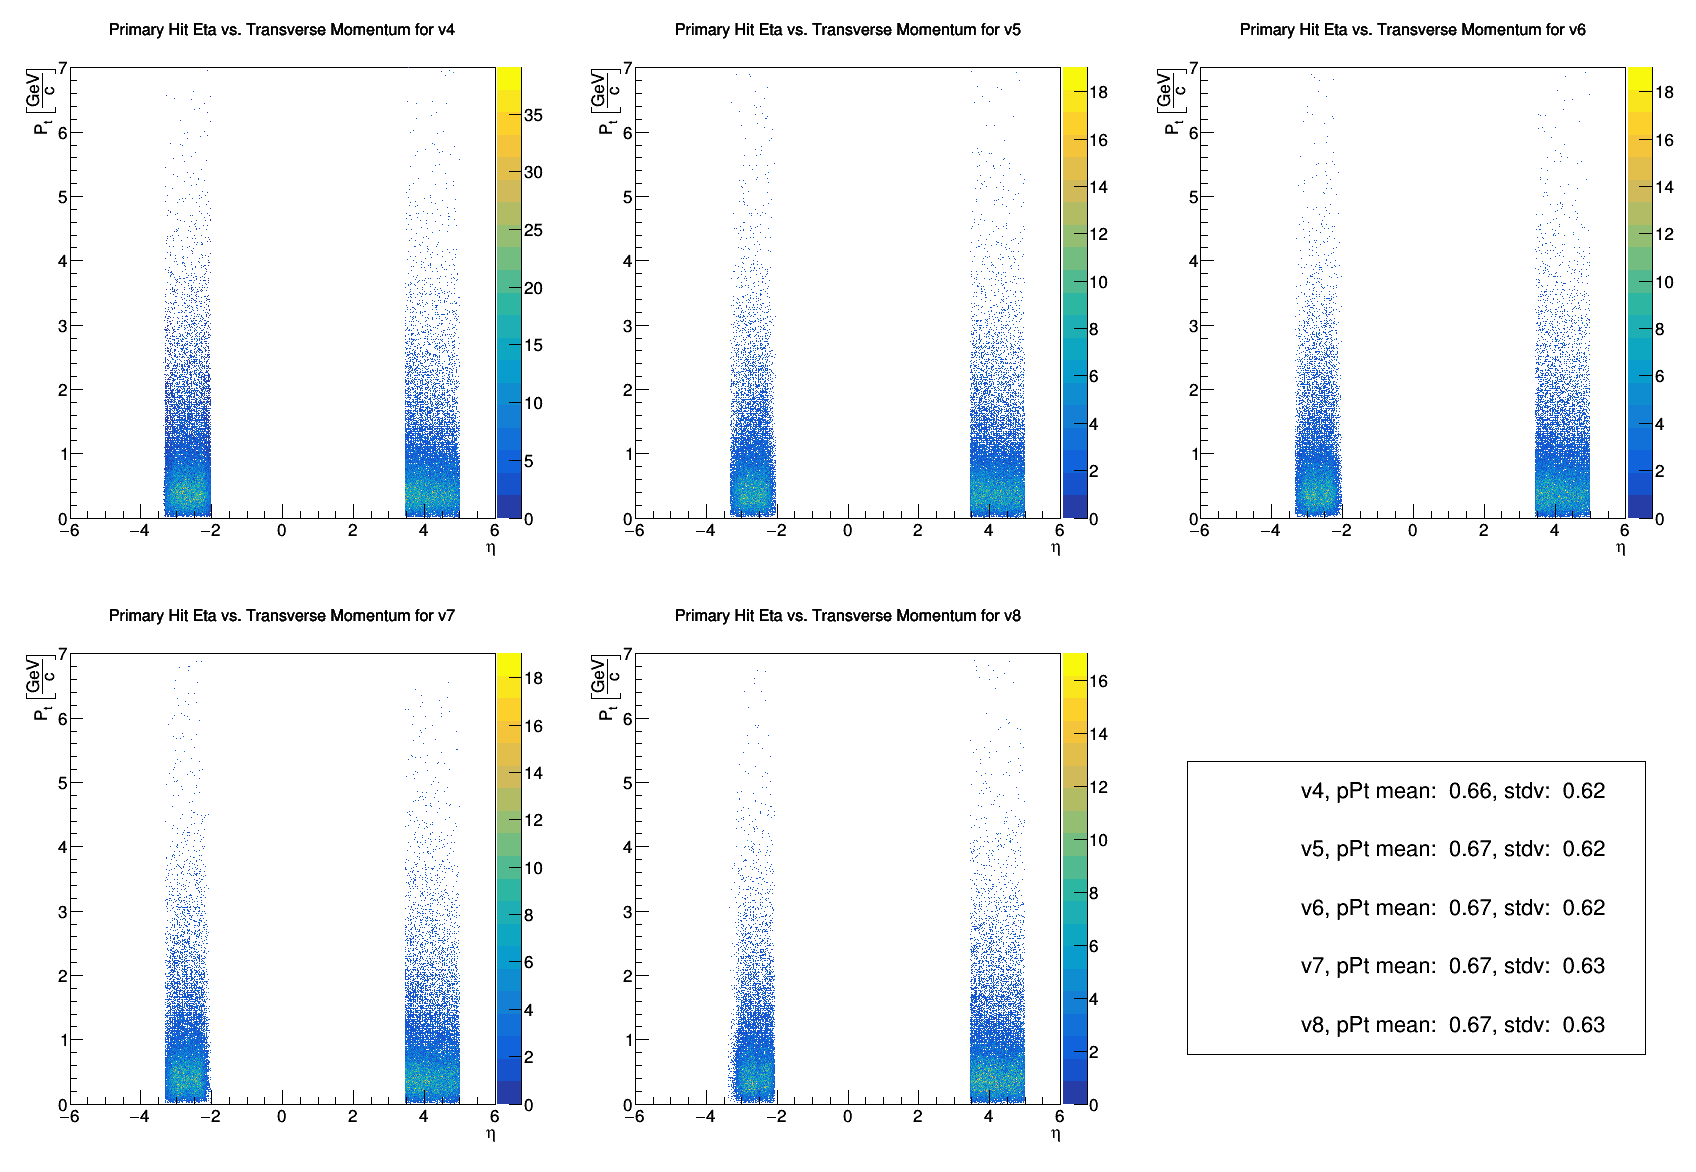

In [36]:
c12 = ROOT.TCanvas("c12","c12",1700,1200)
c12.Divide(3,2)
xmin = -6
xmax = 6
ymin = 0
ymax = 7

pPtEta4.GetXaxis().SetRangeUser(xmin, xmax)
pPtEta4.GetYaxis().SetRangeUser(ymin, ymax)
pPtEta4.SetLineColorAlpha(1, 1)
pPtEta4.SetMarkerColorAlpha(1, 1)
pPtEta4.SetFillColor(1)
pPtEta4.SetFillStyle(3001)

pPtEta5.GetXaxis().SetRangeUser(xmin, xmax)
pPtEta5.GetYaxis().SetRangeUser(ymin, ymax)
pPtEta5.SetLineColorAlpha(4, 1)
pPtEta5.SetMarkerColorAlpha(4, 1)
pPtEta5.SetFillColor(4)
pPtEta5.SetFillStyle(3001)

pPtEta6.GetXaxis().SetRangeUser(xmin, xmax)
pPtEta6.GetYaxis().SetRangeUser(ymin, ymax)
pPtEta6.SetLineColorAlpha(2, 1)
pPtEta6.SetMarkerColorAlpha(2, 1)
pPtEta6.SetFillColor(2)
pPtEta6.SetFillStyle(3001)

pPtEta7.GetXaxis().SetRangeUser(xmin, xmax)
pPtEta7.GetYaxis().SetRangeUser(ymin, ymax)
pPtEta7.SetLineColorAlpha(8, 1)
pPtEta7.SetMarkerColorAlpha(8, 1)
pPtEta7.SetFillColor(8)
pPtEta7.SetFillStyle(3001)

pPtEta8.GetXaxis().SetRangeUser(xmin, xmax)
pPtEta8.GetYaxis().SetRangeUser(ymin, ymax)
pPtEta8.SetLineColorAlpha(9, 1)
pPtEta8.SetMarkerColorAlpha(9, 1)
pPtEta8.SetFillColor(9)
pPtEta8.SetFillStyle(3001)


c12.cd(1)
pPtEta4.Draw("colz")

c12.cd(2)
pPtEta5.Draw("colz")

c12.cd(3)
pPtEta6.Draw("colz")

c12.cd(4)
pPtEta7.Draw("colz")

c12.cd(5)
pPtEta8.Draw("colz")

c12.cd(0)
legend = ROOT.TLegend(0.7,0.35,.97, 0.1)
#legend.SetHeader("The Legend Title")
legend.AddEntry(pPtEta4,"v4, pPt mean: %5.2f, stdv: %5.2f" % (pPtEta4.GetMean(2), pPtEta4.GetStdDev(2))," ")
legend.AddEntry(pPtEta5,"v5, pPt mean: %5.2f, stdv: %5.2f" % (pPtEta5.GetMean(2), pPtEta5.GetStdDev(2))," ")
legend.AddEntry(pPtEta6,"v6, pPt mean: %5.2f, stdv: %5.2f" % (pPtEta6.GetMean(2), pPtEta6.GetStdDev(2))," ")
legend.AddEntry(pPtEta7,"v7, pPt mean: %5.2f, stdv: %5.2f" % (pPtEta7.GetMean(2), pPtEta7.GetStdDev(2))," ")
legend.AddEntry(pPtEta8,"v8, pPt mean: %5.2f, stdv: %5.2f" % (pPtEta8.GetMean(2), pPtEta8.GetStdDev(2))," ")
legend.Draw() 

c12.Draw()

# Efficiency Plots

In [37]:
ef4 = open('../alice1/ali-master/AliRoot/v4/effic.txt', 'r')
ef5 = open('../alice1/ali-master/AliRoot/v5/effic.txt', 'r')
ef6 = open('../alice1/ali-master/AliRoot/v6/effic.txt', 'r')
ef7 = open('../alice1/ali-master/AliRoot/v7/effic.txt', 'r')
ef8 = open('../alice1/ali-master/AliRoot/v8/effic.txt', 'r')

In [38]:
files  = [open('../alice1/ali-master/AliRoot/v' + str(i+4) +'/effic.txt','r') for i in range(5)]
effics = {"v" + str(i + 4) : files[i].readlines() for i in range(len(files))}
for key in effics:
    for i, entry in enumerate(effics[key]):
        effics[key][i] = entry.replace('#','')
        effics[key][i] = effics[key][i].replace('\n','')
    effics[key] = {effics[key][i] : float(effics[key][i + 1]) for i in [0,2]}

In [39]:
def dprint(dic):
    for key in dic:
        print "    ", key, ":", dic[key]
for key in effics:
    print key, ":"
    dprint(effics[key])

v8 :
     && Efficiency : 49.0675
     || Efficiency : 85.0879
v4 :
     && Efficiency : 62.7387
     || Efficiency : 90.9206
v5 :
     && Efficiency : 54.7539
     || Efficiency : 87.8365
v6 :
     && Efficiency : 54.7193
     || Efficiency : 87.8261
v7 :
     && Efficiency : 54.4804
     || Efficiency : 87.6663


#### Log Scale?

In [40]:
log = False

## Number of primaries for events with expected primary detection

In [41]:
nptrue4 = f4.Get("v4nptrue")
nptrue5 = f5.Get("v5nptrue")
nptrue6 = f6.Get("v6nptrue")
nptrue7 = f7.Get("v7nptrue")
nptrue8 = f8.Get("v8nptrue")

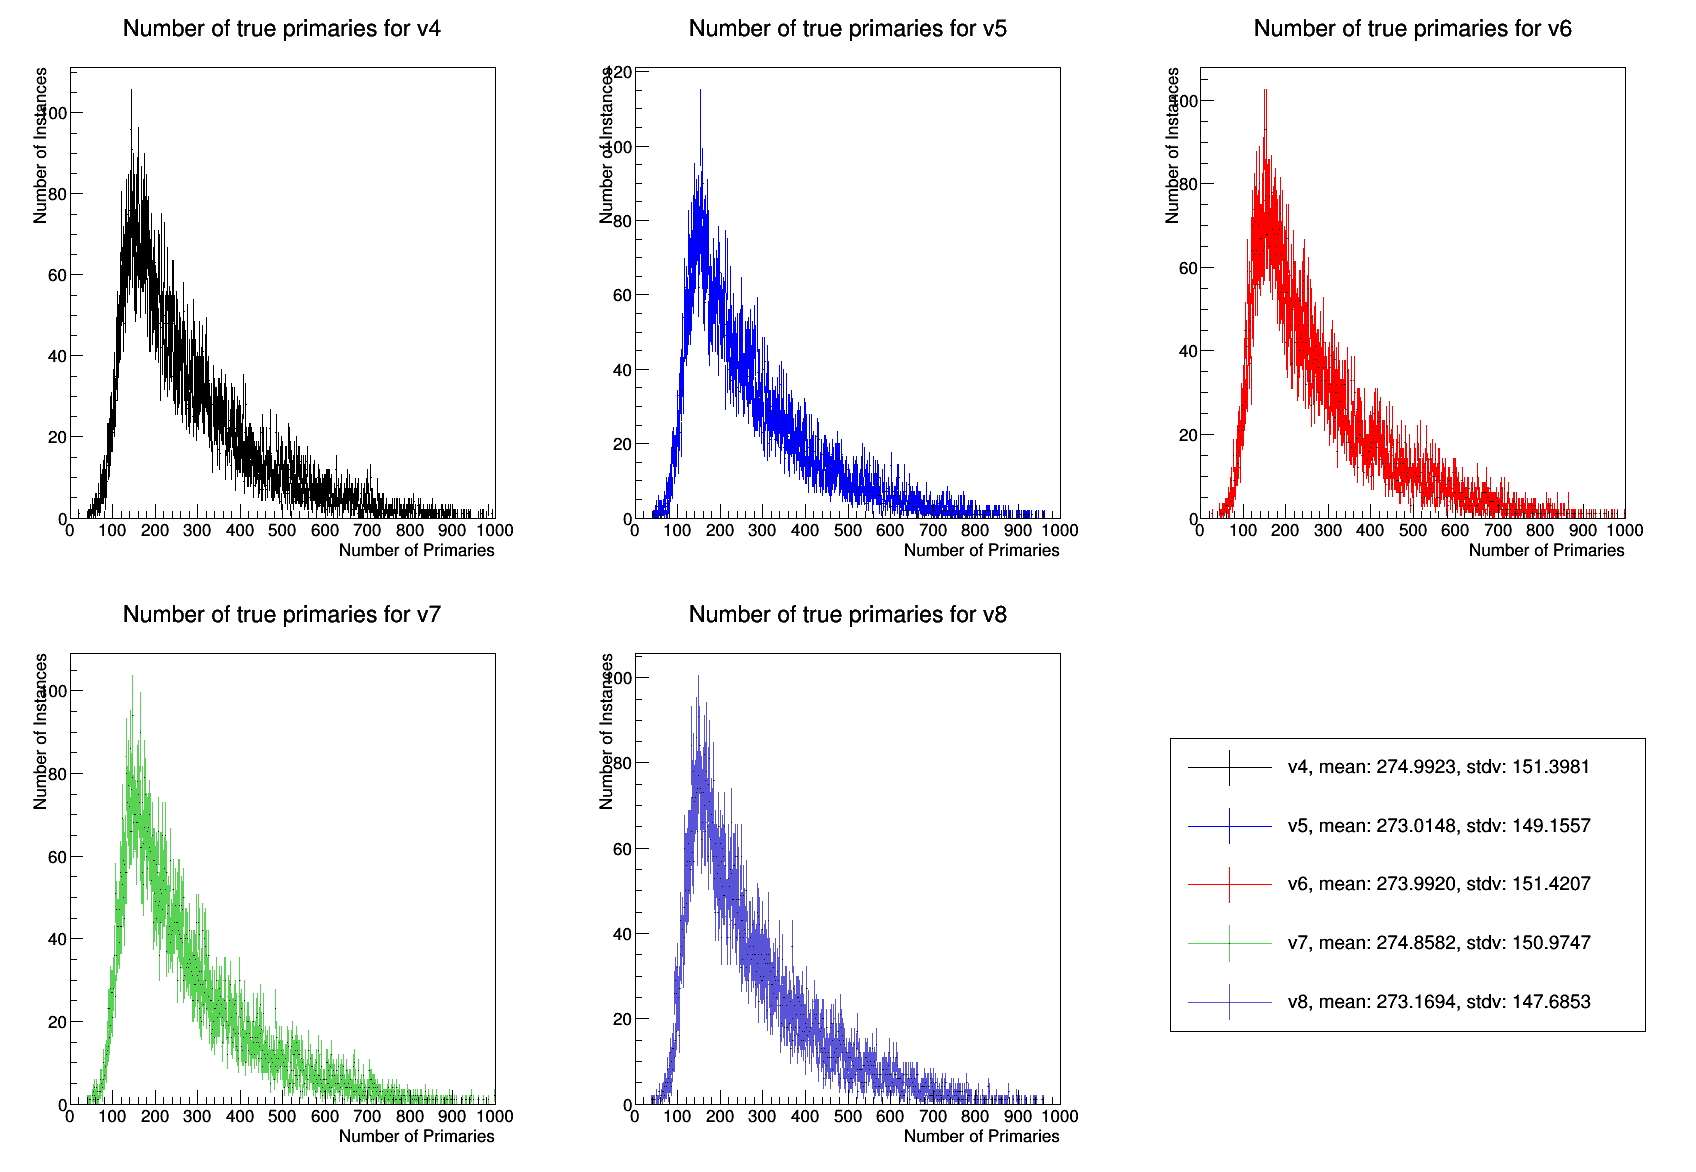

In [42]:
c13 = ROOT.TCanvas("c13","c13", 1700,1200)

c13.Divide(3,2)

xmin = 0
xmax = 1000

nptrue4.GetXaxis().SetRangeUser(xmin, xmax)
nptrue4.SetLineColorAlpha(1, 1)
nptrue4.SetLineWidth(1)

nptrue5.GetXaxis().SetRangeUser(xmin, xmax)
nptrue5.SetLineColorAlpha(4, 1)
nptrue5.SetLineWidth(1)

nptrue6.GetXaxis().SetRangeUser(xmin, xmax)
nptrue6.SetLineColorAlpha(2, 1)
nptrue6.SetLineWidth(1)

nptrue7.GetXaxis().SetRangeUser(xmin, xmax)
nptrue7.SetLineColorAlpha(8, 1)
nptrue7.SetLineWidth(1)

nptrue8.GetXaxis().SetRangeUser(xmin, xmax)
nptrue8.SetLineColorAlpha(9, 1)
nptrue8.SetLineWidth(1)


p1 = c13.cd(1)
if log:
    p1.SetLogy()
nptrue4.Draw("P")

p2 = c13.cd(2)
if log:
    p2.SetLogy()
nptrue5.Draw("P")

p3 = c13.cd(3)
if log:
    p3.SetLogy()
nptrue6.Draw("P")

p4 = c13.cd(4)
if log:
    p4.SetLogy()
nptrue7.Draw("P")

p5 = c13.cd(5)
if log:
    p5.SetLogy()
nptrue8.Draw("P")

c13.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
#legend.SetHeader("The Legend Title")
legend.AddEntry(nptrue4,"v4, mean: %7.4f, stdv: %5.4f" % (nptrue4.GetMean(), nptrue4.GetStdDev()),"lep")
legend.AddEntry(nptrue5,"v5, mean: %7.4f, stdv: %5.4f" % (nptrue5.GetMean(), nptrue5.GetStdDev()),"lep")
legend.AddEntry(nptrue6,"v6, mean: %7.4f, stdv: %5.4f" % (nptrue6.GetMean(), nptrue6.GetStdDev()),"lep")
legend.AddEntry(nptrue7,"v7, mean: %7.4f, stdv: %5.4f" % (nptrue7.GetMean(), nptrue7.GetStdDev()),"lep")
legend.AddEntry(nptrue8,"v8, mean: %7.4f, stdv: %5.4f" % (nptrue8.GetMean(), nptrue8.GetStdDev()),"lep")
legend.Draw()

c13.Draw()

## Number of primaries for events with & measured primary detection

In [43]:
npmeas4 = f4.Get("v4npmeas")
npmeas5 = f5.Get("v5npmeas")
npmeas6 = f6.Get("v6npmeas")
npmeas7 = f7.Get("v7npmeas")
npmeas8 = f8.Get("v8npmeas")

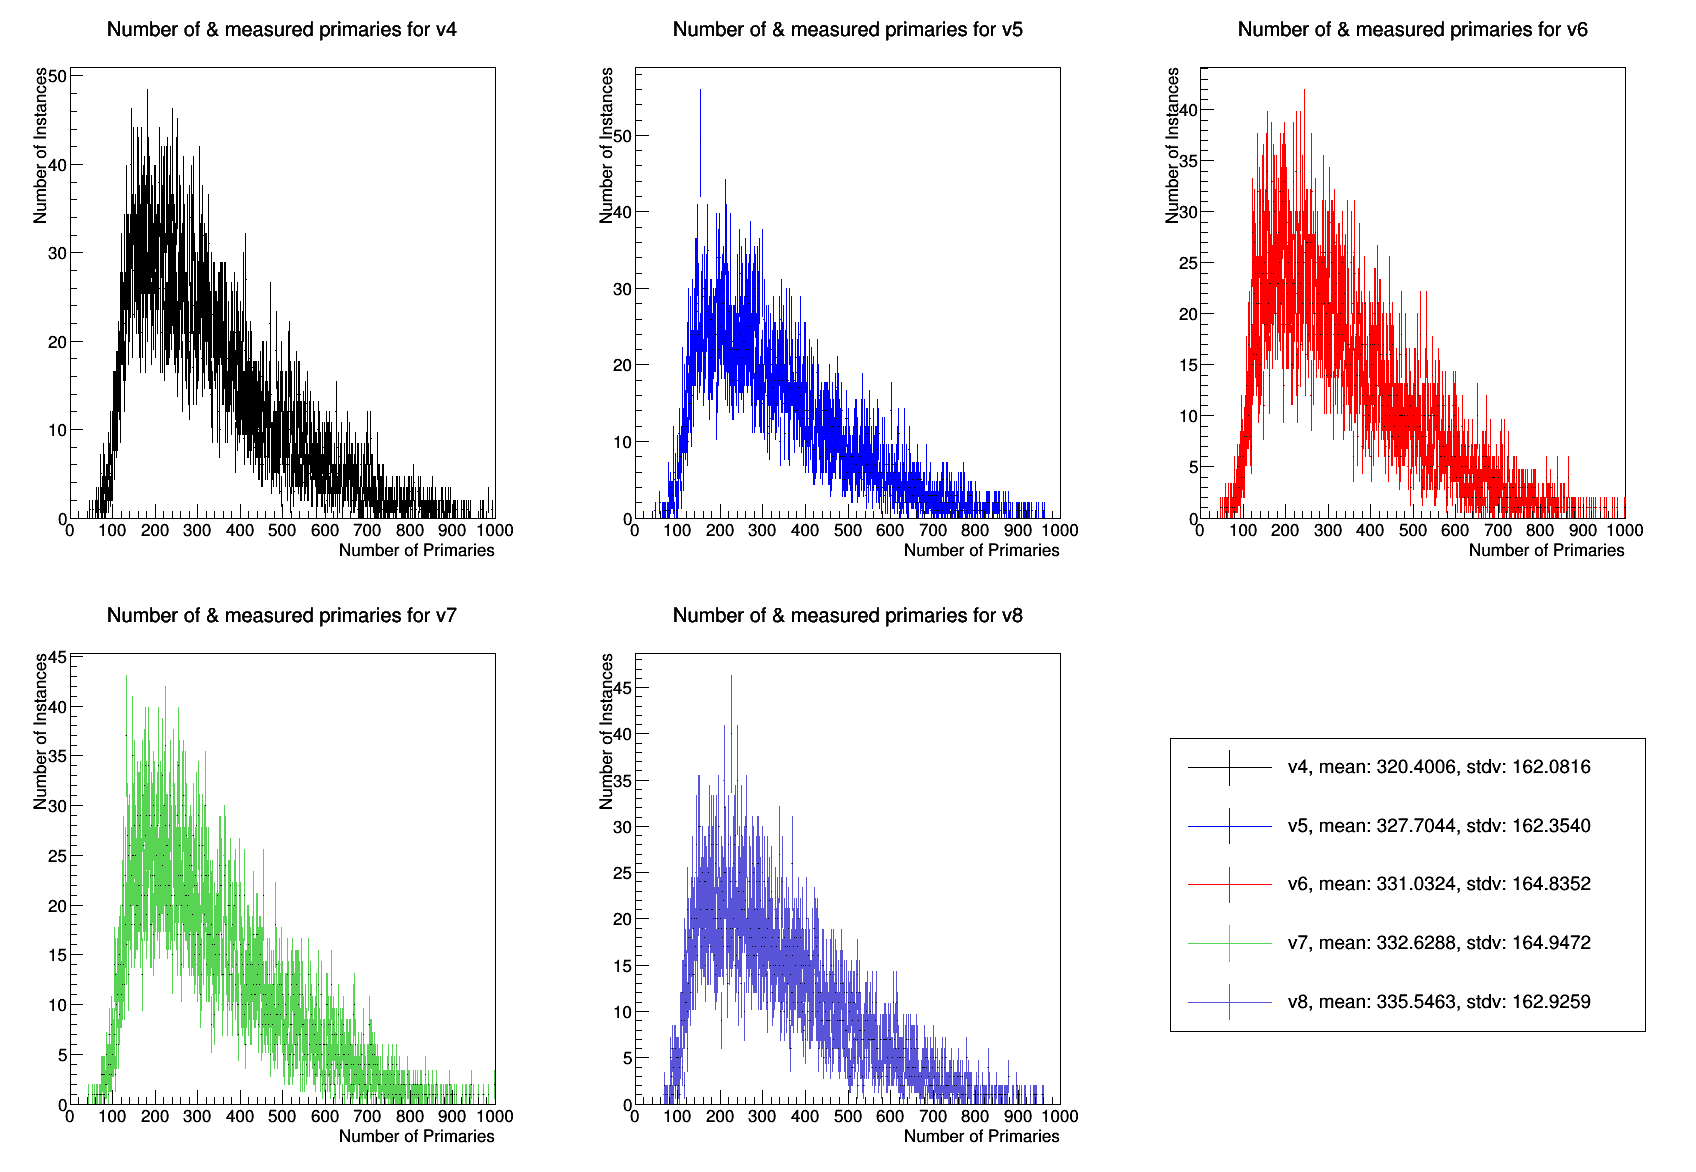

In [44]:
c14 = ROOT.TCanvas("c14","c14", 1700,1200)

c14.Divide(3,2)

xmin = 0
xmax = 1000

npmeas4.GetXaxis().SetRangeUser(xmin, xmax)
npmeas4.SetLineColorAlpha(1, 1)

npmeas5.GetXaxis().SetRangeUser(xmin, xmax)
npmeas5.SetLineColorAlpha(4, 1)

npmeas6.GetXaxis().SetRangeUser(xmin, xmax)
npmeas6.SetLineColorAlpha(2, 1)

npmeas7.GetXaxis().SetRangeUser(xmin, xmax)
npmeas7.SetLineColorAlpha(8, 1)

npmeas8.GetXaxis().SetRangeUser(xmin, xmax)
npmeas8.SetLineColorAlpha(9, 1)


p1 = c14.cd(1)
if log:
    p1.SetLogy()
npmeas4.Draw()

p2 = c14.cd(2)
if log:
    p2.SetLogy()
npmeas5.Draw()

p3 = c14.cd(3)
if log:
    p3.SetLogy()
npmeas6.Draw()

p4 = c14.cd(4)
if log:
    p4.SetLogy()
npmeas7.Draw()

p5 = c14.cd(5)
if log:
    p5.SetLogy()
npmeas8.Draw()

c14.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
#legend.SetHeader("The Legend Title")
legend.AddEntry(npmeas4,"v4, mean: %7.4f, stdv: %5.4f" % (npmeas4.GetMean(), npmeas4.GetStdDev()),"le")
legend.AddEntry(npmeas5,"v5, mean: %7.4f, stdv: %5.4f" % (npmeas5.GetMean(), npmeas5.GetStdDev()),"le")
legend.AddEntry(npmeas6,"v6, mean: %7.4f, stdv: %5.4f" % (npmeas6.GetMean(), npmeas6.GetStdDev()),"le")
legend.AddEntry(npmeas7,"v7, mean: %7.4f, stdv: %5.4f" % (npmeas7.GetMean(), npmeas7.GetStdDev()),"le")
legend.AddEntry(npmeas8,"v8, mean: %7.4f, stdv: %5.4f" % (npmeas8.GetMean(), npmeas8.GetStdDev()),"le")
legend.Draw()

c14.Draw()

## Number of primaries for events with expected / measured primary detection

In [45]:
v4hs3 = f4.Get("hs3")
v5hs3 = f5.Get("hs3")
v6hs3 = f6.Get("hs3")
v7hs3 = f7.Get("hs3")
v8hs3 = f8.Get("hs3")

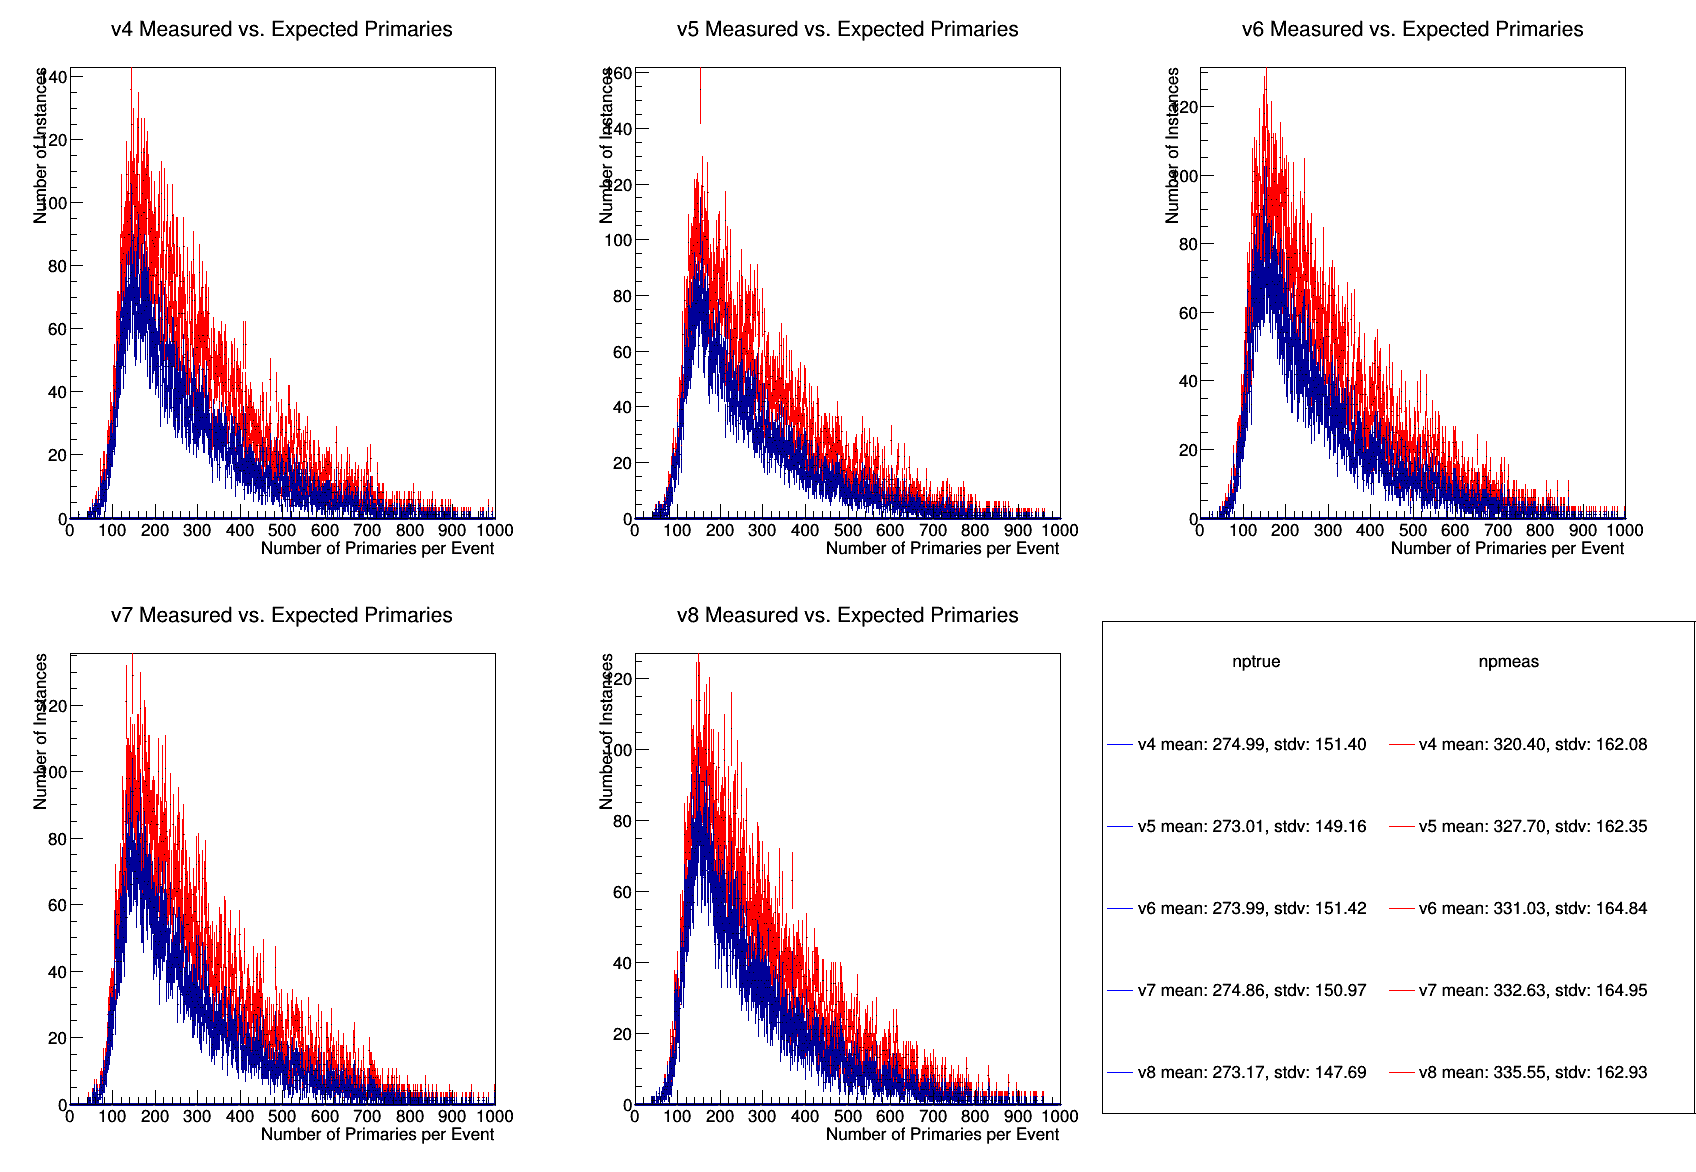

In [46]:
c15 = ROOT.TCanvas("c15","c15",1700,1200)
c15.Divide(3,2)
xmin = 0
xmax = 1000
ymin = 0
ymax = 10


nptrue4.SetLineColorAlpha(4, 1)
nptrue5.SetLineColorAlpha(4, 1)
nptrue6.SetLineColorAlpha(4, 1)
nptrue7.SetLineColorAlpha(4, 1)
nptrue8.SetLineColorAlpha(4, 1)

npmeas4.SetLineColorAlpha(2, 1)
npmeas5.SetLineColorAlpha(2, 1)
npmeas6.SetLineColorAlpha(2, 1)
npmeas7.SetLineColorAlpha(2, 1)
npmeas8.SetLineColorAlpha(2, 1)


c15.cd(1)
#if log:
    #v4hs3.SetLogy()
v4hs3.Draw()
v4hs3.GetXaxis().SetTitle("Number of Primaries per Event")
v4hs3.GetYaxis().SetTitle("Number of Instances")
v4hs3.GetXaxis().SetRangeUser(xmin, xmax)

c15.cd(2)
#if log:
    #v5hs3.SetLogy()
v5hs3.Draw()
v5hs3.GetXaxis().SetTitle("Number of Primaries per Event")
v5hs3.GetYaxis().SetTitle("Number of Instances")
v5hs3.GetXaxis().SetRangeUser(xmin, xmax)

c15.cd(3)
#if log:
    #v6hs3.SetLogy()
v6hs3.Draw()
v6hs3.GetXaxis().SetTitle("Number of Primaries per Event")
v6hs3.GetYaxis().SetTitle("Number of Instances")
v6hs3.GetXaxis().SetRangeUser(xmin, xmax)

c15.cd(4)
#if log:
    #v7hs3.SetLogy()
v7hs3.Draw()
v7hs3.GetXaxis().SetTitle("Number of Primaries per Event")
v7hs3.GetYaxis().SetTitle("Number of Instances")
v7hs3.GetXaxis().SetRangeUser(xmin, xmax)

c15.cd(5)
#if log:
    #v8hs3.SetLogy()
v8hs3.Draw()
v8hs3.GetXaxis().SetTitle("Number of Primaries per Event")
v8hs3.GetYaxis().SetTitle("Number of Instances")
v8hs3.GetXaxis().SetRangeUser(xmin, xmax)

c15.cd(0)
legend = ROOT.TLegend(0.65,0.47,1, 0.05)
legend.SetHeader("                           nptrue                                          npmeas")
legend.SetNColumns(2)
legend.SetMargin(0.12)
legend.SetEntrySeparation(0)
legend.SetColumnSeparation(-.05)
legend.AddEntry(nptrue4,"v4 mean: %5.2f, stdv: %5.2f" % (nptrue4.GetMean(1), nptrue4.GetStdDev(1)),"l")
legend.AddEntry(npmeas4,"v4 mean: %5.2f, stdv: %5.2f" % (npmeas4.GetMean(1), npmeas4.GetStdDev(1)),"l")
legend.AddEntry(nptrue5,"v5 mean: %5.2f, stdv: %5.2f" % (nptrue5.GetMean(1), nptrue5.GetStdDev(1)),"l")
legend.AddEntry(npmeas5,"v5 mean: %5.2f, stdv: %5.2f" % (npmeas5.GetMean(1), npmeas5.GetStdDev(1)),"l")
legend.AddEntry(nptrue6,"v6 mean: %5.2f, stdv: %5.2f" % (nptrue6.GetMean(1), nptrue6.GetStdDev(1)),"l")
legend.AddEntry(npmeas6,"v6 mean: %5.2f, stdv: %5.2f" % (npmeas6.GetMean(1), npmeas6.GetStdDev(1)),"l")
legend.AddEntry(nptrue7,"v7 mean: %5.2f, stdv: %5.2f" % (nptrue7.GetMean(1), nptrue7.GetStdDev(1)),"l")
legend.AddEntry(npmeas7,"v7 mean: %5.2f, stdv: %5.2f" % (npmeas7.GetMean(1), npmeas7.GetStdDev(1)),"l")
legend.AddEntry(nptrue8,"v8 mean: %5.2f, stdv: %5.2f" % (nptrue8.GetMean(1), nptrue8.GetStdDev(1)),"l")
legend.AddEntry(npmeas8,"v8 mean: %5.2f, stdv: %5.2f" % (npmeas8.GetMean(1), npmeas8.GetStdDev(1)),"l")
legend.Draw()

c15.Draw()

## & Efficiency as a function of number of primaries per event

In [47]:
rebinner = 10

In [48]:
effich4 = f4.Get("v4effich")
effich5 = f5.Get("v5effich")
effich6 = f6.Get("v6effich")
effich7 = f7.Get("v7effich")
effich8 = f8.Get("v8effich")

effich4.Rebin(rebinner)
effich5.Rebin(rebinner)
effich6.Rebin(rebinner)
effich7.Rebin(rebinner)
effich8.Rebin(rebinner)

effich4.Scale(1/float(rebinner))
effich5.Scale(1/float(rebinner))
effich6.Scale(1/float(rebinner))
effich7.Scale(1/float(rebinner))
effich8.Scale(1/float(rebinner))

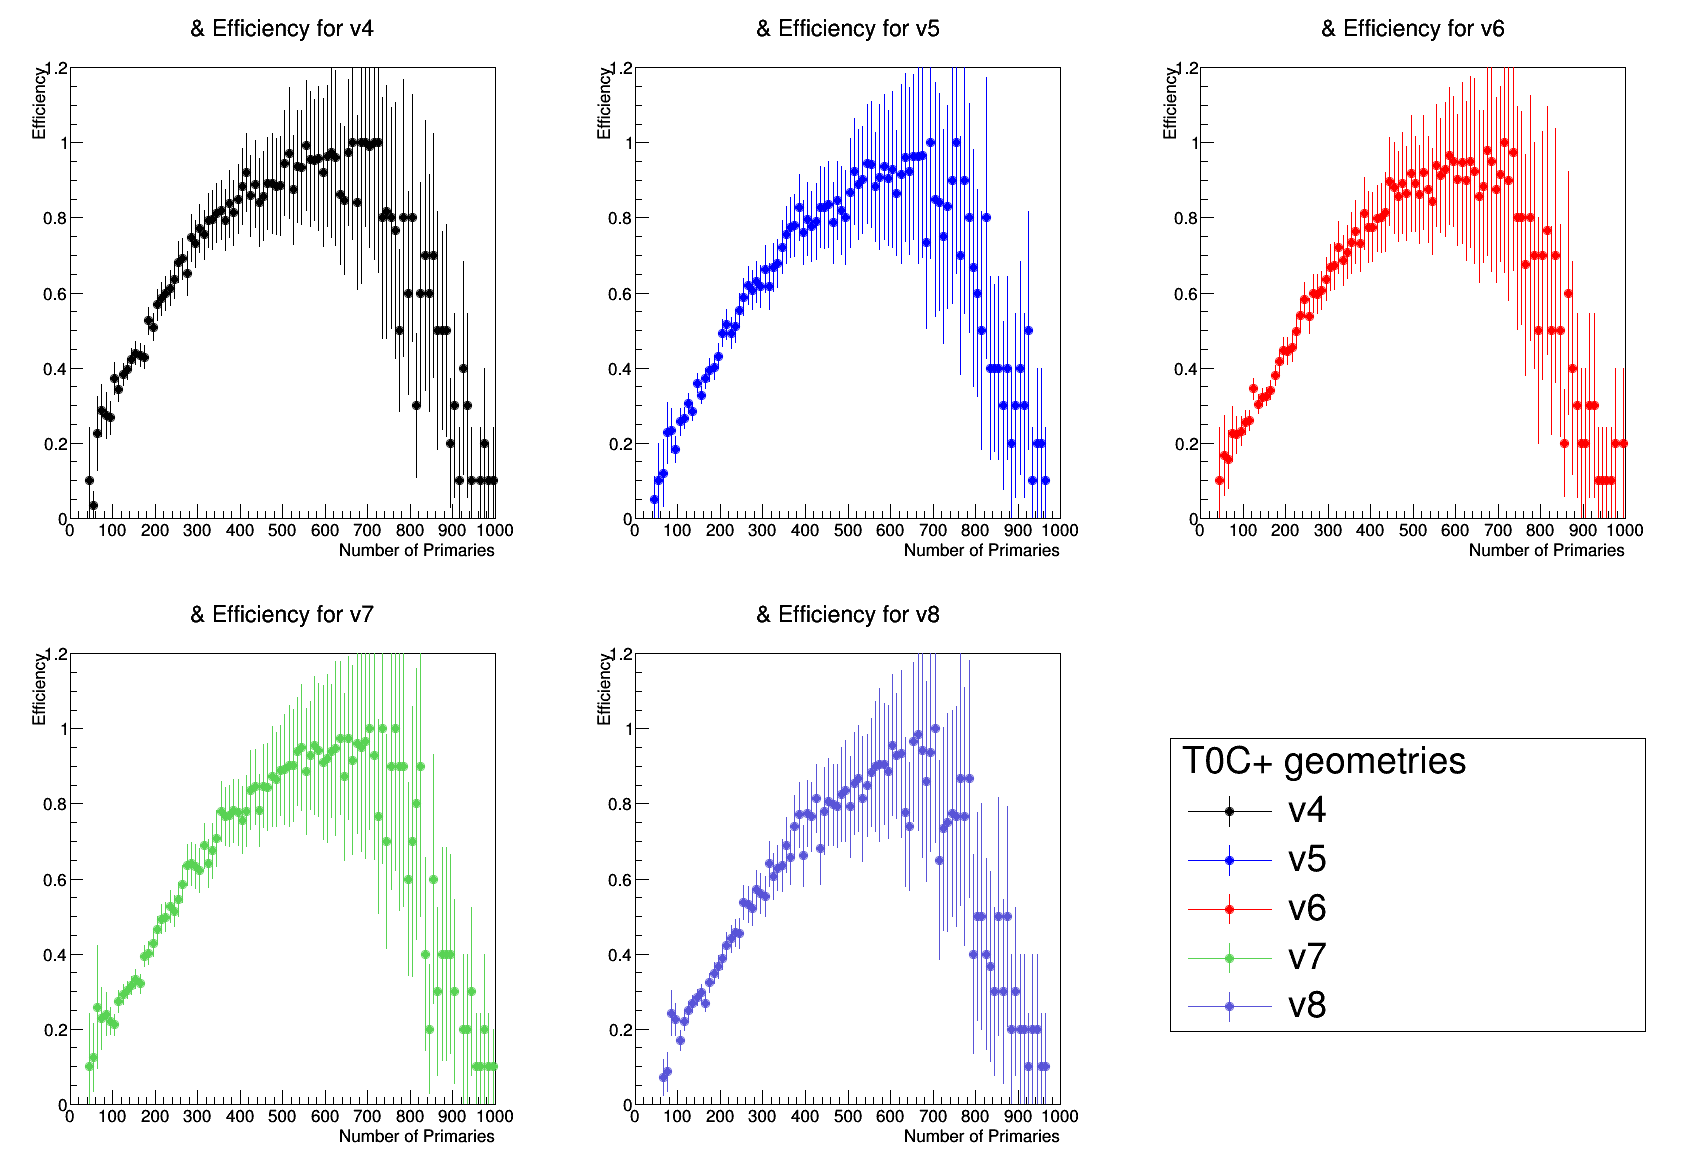

In [49]:
c16 = ROOT.TCanvas("c16","c16", 1700,1200)


c16.Divide(3,2)

xmin = 0
xmax = 1000

effich4.GetXaxis().SetRangeUser(xmin, xmax)
effich4.GetYaxis().SetRangeUser(0, 1.2)
effich4.SetLineColorAlpha(1, 1)
effich4.SetMarkerStyle(8)
effich4.SetMarkerColorAlpha(1, 1)
effich4.GetYaxis().SetTitle("Efficiency")

effich5.GetXaxis().SetRangeUser(xmin, xmax)
effich5.GetYaxis().SetRangeUser(0, 1.2)
effich5.SetLineColorAlpha(4, 1)
effich5.SetMarkerStyle(8)
effich5.SetMarkerColorAlpha(4, 1)
effich5.GetYaxis().SetTitle("Efficiency")

effich6.GetXaxis().SetRangeUser(xmin, xmax)
effich6.GetYaxis().SetRangeUser(0, 1.2)
effich6.SetLineColorAlpha(2, 1)
effich6.SetMarkerStyle(8)
effich6.SetMarkerColorAlpha(2, 1)
effich6.GetYaxis().SetTitle("Efficiency")

effich7.GetXaxis().SetRangeUser(xmin, xmax)
effich7.GetYaxis().SetRangeUser(0, 1.2)
effich7.SetLineColorAlpha(8, 1)
effich7.SetMarkerStyle(8)
effich7.SetMarkerColorAlpha(8, 1)
effich7.GetYaxis().SetTitle("Efficiency")

effich8.GetXaxis().SetRangeUser(xmin, xmax)
effich8.GetYaxis().SetRangeUser(0, 1.2)
effich8.SetLineColorAlpha(9, 1)
effich8.SetMarkerStyle(8)
effich8.SetMarkerColorAlpha(9, 1)
effich8.GetYaxis().SetTitle("Efficiency")


p1 = c16.cd(1)
if log:
    p1.SetLogy()
effich4.Draw()

p2 = c16.cd(2)
if log:
    p2.SetLogy()
effich5.Draw()

p3 = c16.cd(3)
if log:
    p3.SetLogy()
effich6.Draw()

p4 = c16.cd(4)
if log:
    p4.SetLogy()
effich7.Draw()

p5 = c16.cd(5)
if log:
    p5.SetLogy()
effich8.Draw()

c16.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
legend.SetHeader("T0C+ geometries")
legend.AddEntry(effich4,"v4","lep")
legend.AddEntry(effich5,"v5","lep")
legend.AddEntry(effich6,"v6","lep")
legend.AddEntry(effich7,"v7","lep")
legend.AddEntry(effich8,"v8","lep")
legend.Draw()

c16.Draw()

## Number of primaries for events with || measured primary detection

In [50]:
npmeas4e = f4.Get("v4npmeas2")
npmeas5e = f5.Get("v5npmeas2")
npmeas6e = f6.Get("v6npmeas2")
npmeas7e = f7.Get("v7npmeas2")
npmeas8e = f8.Get("v8npmeas2")

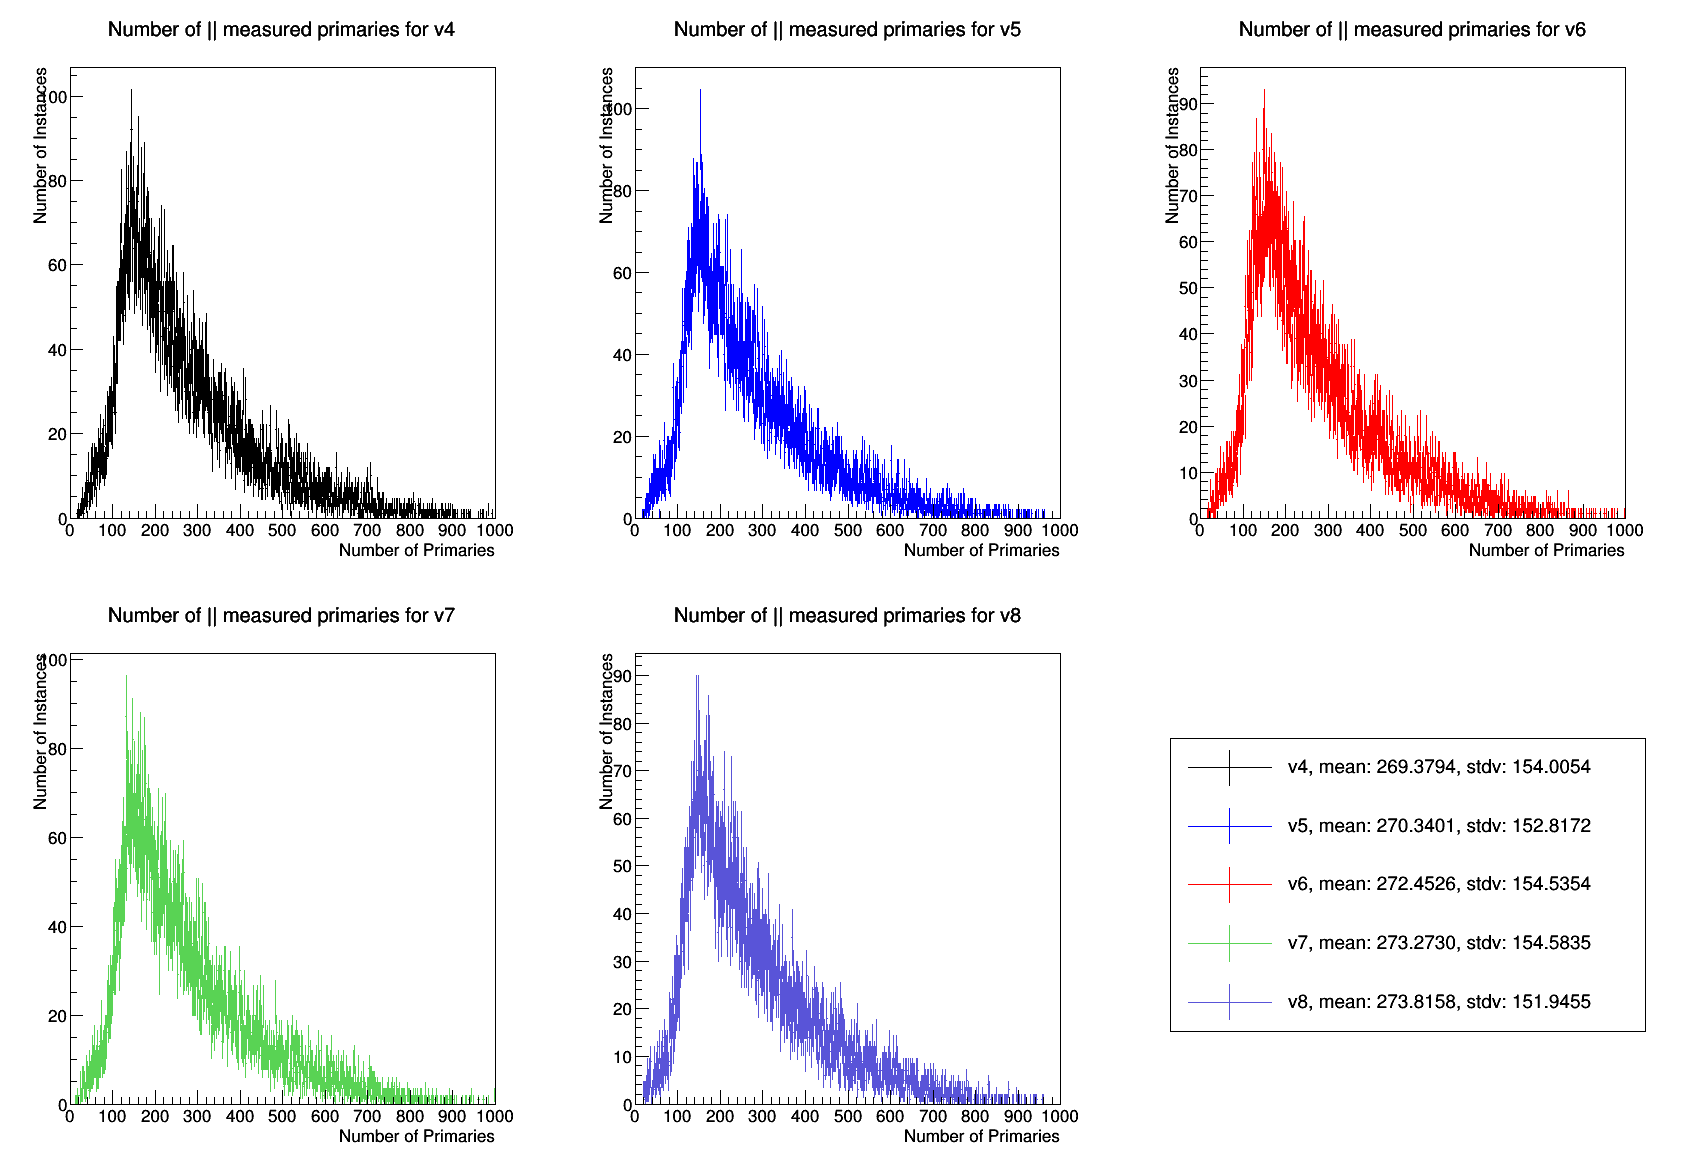

In [51]:
c17 = ROOT.TCanvas("c17","c17", 1700,1200)

c17.Divide(3,2)

xmin = 0
xmax = 1000

npmeas4e.GetXaxis().SetRangeUser(xmin, xmax)
npmeas4e.SetLineColorAlpha(1, 1)
#npmeas4e.SetMarkerStyle(8)
npmeas4e.SetMarkerColor(1)

npmeas5e.GetXaxis().SetRangeUser(xmin, xmax)
npmeas5e.SetLineColorAlpha(4, 1)
#npmeas5e.SetMarkerStyle(8)
npmeas5e.SetMarkerColor(4)

npmeas6e.GetXaxis().SetRangeUser(xmin, xmax)
npmeas6e.SetLineColorAlpha(2, 1)
#npmeas6e.SetMarkerStyle(8)
npmeas6e.SetMarkerColor(2)

npmeas7e.GetXaxis().SetRangeUser(xmin, xmax)
npmeas7e.SetLineColorAlpha(8, 1)
#npmeas7e.SetMarkerStyle(8)
npmeas7e.SetMarkerColor(8)

npmeas8e.GetXaxis().SetRangeUser(xmin, xmax)
npmeas8e.SetLineColorAlpha(9, 1)
#npmeas8e.SetMarkerStyle(8)
npmeas8e.SetMarkerColor(9)


p1 = c17.cd(1)
if log:
    p1.SetLogy()
npmeas4e.Draw()

p2 = c17.cd(2)
if log:
    p2.SetLogy()
npmeas5e.Draw()

p3 = c17.cd(3)
if log:
    p3.SetLogy()
npmeas6e.Draw()

p4 = c17.cd(4)
if log:
    p4.SetLogy()
npmeas7e.Draw()

p5 = c17.cd(5)
if log:
    p5.SetLogy()
npmeas8e.Draw()

c17.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
#legend.SetHeader("The Legend Title")
legend.AddEntry(npmeas4e,"v4, mean: %7.4f, stdv: %5.4f" % (npmeas4e.GetMean(), npmeas4e.GetStdDev()),"le")
legend.AddEntry(npmeas5e,"v5, mean: %7.4f, stdv: %5.4f" % (npmeas5e.GetMean(), npmeas5e.GetStdDev()),"le")
legend.AddEntry(npmeas6e,"v6, mean: %7.4f, stdv: %5.4f" % (npmeas6e.GetMean(), npmeas6e.GetStdDev()),"le")
legend.AddEntry(npmeas7e,"v7, mean: %7.4f, stdv: %5.4f" % (npmeas7e.GetMean(), npmeas7e.GetStdDev()),"le")
legend.AddEntry(npmeas8e,"v8, mean: %7.4f, stdv: %5.4f" % (npmeas8e.GetMean(), npmeas8e.GetStdDev()),"le")
legend.Draw()

c17.Draw()

## || Efficiency as a function of number of primaries per event

In [52]:
effich4e = f4.Get("v4effich2")
effich5e = f5.Get("v5effich2")
effich6e = f6.Get("v6effich2")
effich7e = f7.Get("v7effich2")
effich8e = f8.Get("v8effich2")

effich4e.Rebin(rebinner)
effich5e.Rebin(rebinner)
effich6e.Rebin(rebinner)
effich7e.Rebin(rebinner)
effich8e.Rebin(rebinner)

effich4e.Scale(1/float(rebinner))
effich5e.Scale(1/float(rebinner))
effich6e.Scale(1/float(rebinner))
effich7e.Scale(1/float(rebinner))
effich8e.Scale(1/float(rebinner))

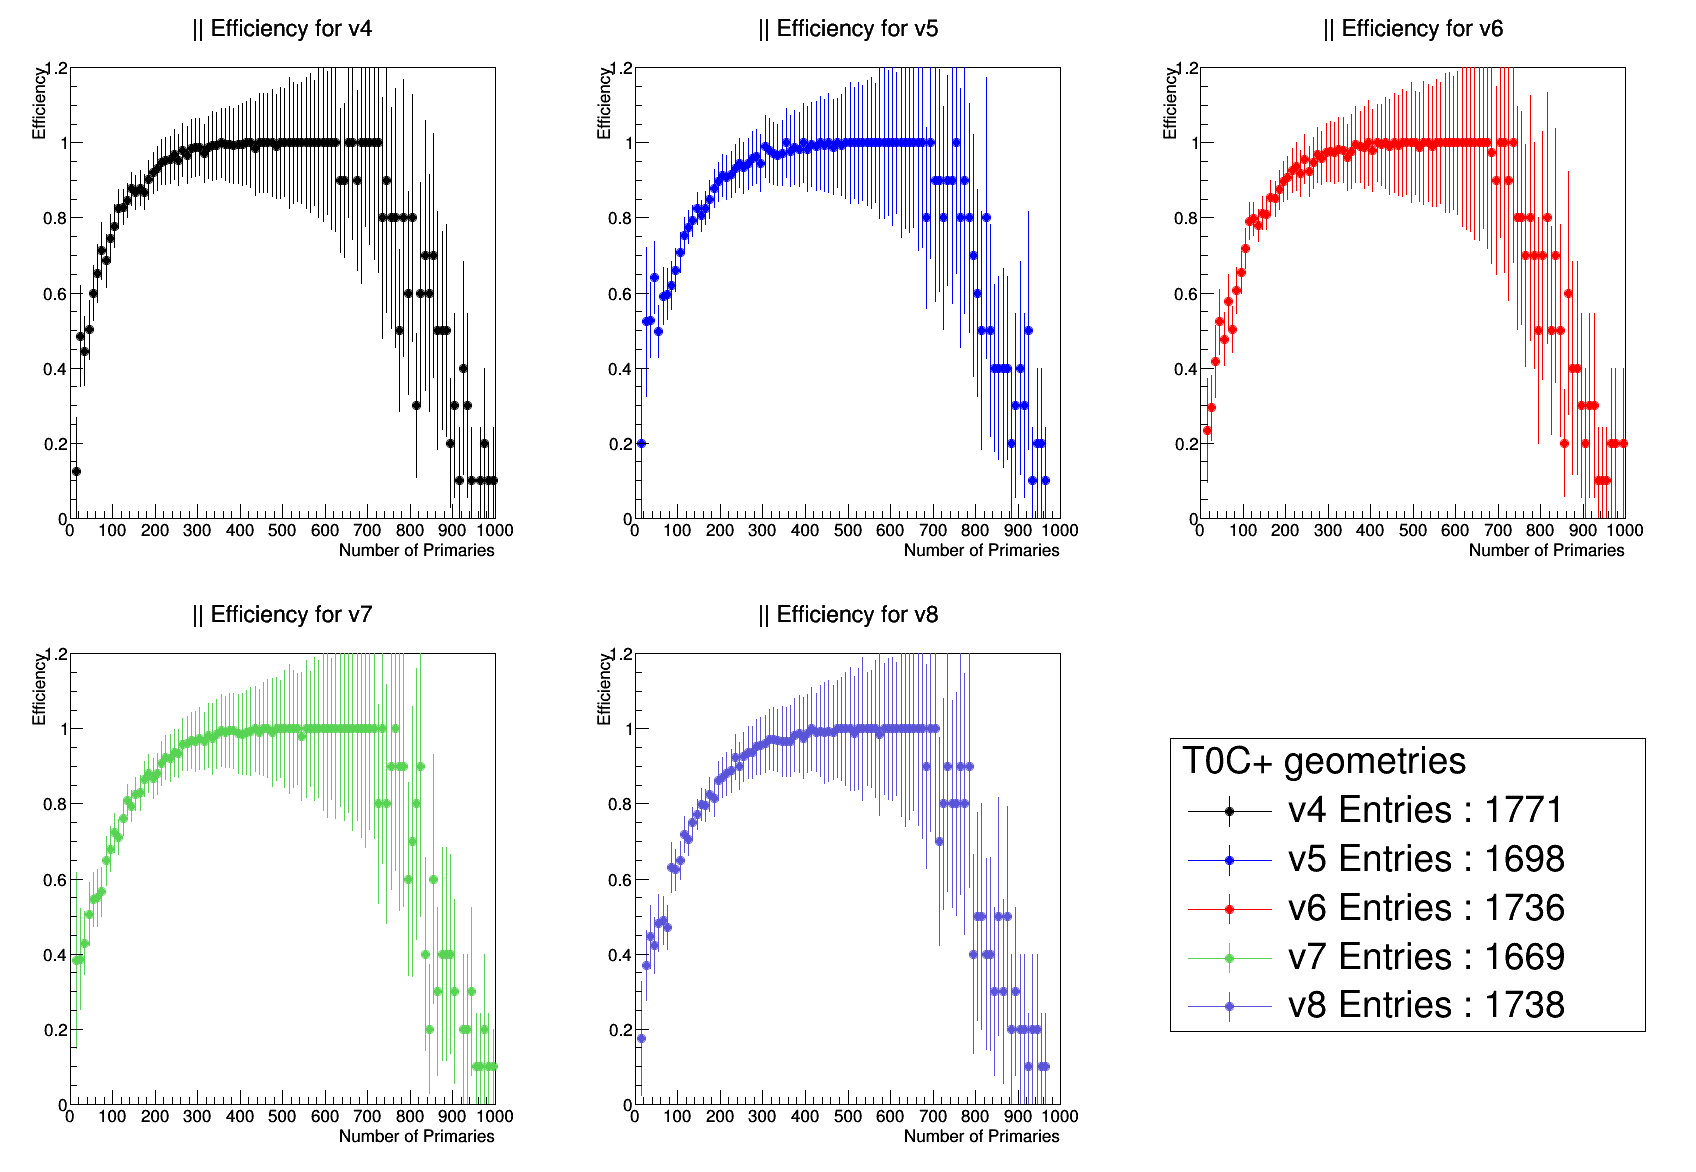

In [53]:
c18 = ROOT.TCanvas("c18","c18", 1700,1200)


c18.Divide(3,2)

xmin = 0
xmax = 1000

effich4e.GetXaxis().SetRangeUser(xmin, xmax)
effich4e.GetYaxis().SetRangeUser(0, 1.2)
effich4e.SetLineColorAlpha(1, 1)
effich4e.SetMarkerStyle(8)
effich4e.SetMarkerColorAlpha(1, 1)
effich4e.GetYaxis().SetTitle("Efficiency")

effich5e.GetXaxis().SetRangeUser(xmin, xmax)
effich5e.GetYaxis().SetRangeUser(0, 1.2)
effich5e.SetLineColorAlpha(4, 1)
effich5e.SetMarkerStyle(8)
effich5e.SetMarkerColorAlpha(4, 1)
effich5e.GetYaxis().SetTitle("Efficiency")

effich6e.GetXaxis().SetRangeUser(xmin, xmax)
effich6e.GetYaxis().SetRangeUser(0, 1.2)
effich6e.SetLineColorAlpha(2, 1)
effich6e.SetMarkerStyle(8)
effich6e.SetMarkerColorAlpha(2, 1)
effich6e.GetYaxis().SetTitle("Efficiency")

effich7e.GetXaxis().SetRangeUser(xmin, xmax)
effich7e.GetYaxis().SetRangeUser(0, 1.2)
effich7e.SetLineColorAlpha(8, 1)
effich7e.SetMarkerStyle(8)
effich7e.SetMarkerColorAlpha(8, 1)
effich7e.GetYaxis().SetTitle("Efficiency")

effich8e.GetXaxis().SetRangeUser(xmin, xmax)
effich8e.GetYaxis().SetRangeUser(0, 1.2)
effich8e.SetLineColorAlpha(9, 1)
effich8e.SetMarkerStyle(8)
effich8e.SetMarkerColorAlpha(9, 1)
effich8e.GetYaxis().SetTitle("Efficiency")


p1 = c18.cd(1)
if log:
    p1.SetLogy()
effich4e.Draw()

p2 = c18.cd(2)
if log:
    p2.SetLogy()
effich5e.Draw()

p3 = c18.cd(3)
if log:
    p3.SetLogy()
effich6e.Draw()

p4 = c18.cd(4)
if log:
    p4.SetLogy()
effich7e.Draw()

p5 = c18.cd(5)
if log:
    p5.SetLogy()
effich8e.Draw()

c18.cd(0)
legend = ROOT.TLegend(0.69,0.37,.97, 0.12)
legend.SetHeader("T0C+ geometries")
legend.AddEntry(effich4e,"v4 Entries : %d" % (effich4e.GetEntries()),"lep")
legend.AddEntry(effich5e,"v5 Entries : %d" % (effich5e.GetEntries()),"lep")
legend.AddEntry(effich6e,"v6 Entries : %d" % (effich6e.GetEntries()),"lep")
legend.AddEntry(effich7e,"v7 Entries : %d" % (effich7e.GetEntries()),"lep")
legend.AddEntry(effich8e,"v8 Entries : %d" % (effich8e.GetEntries()),"lep")
legend.Draw()

c18.Draw()

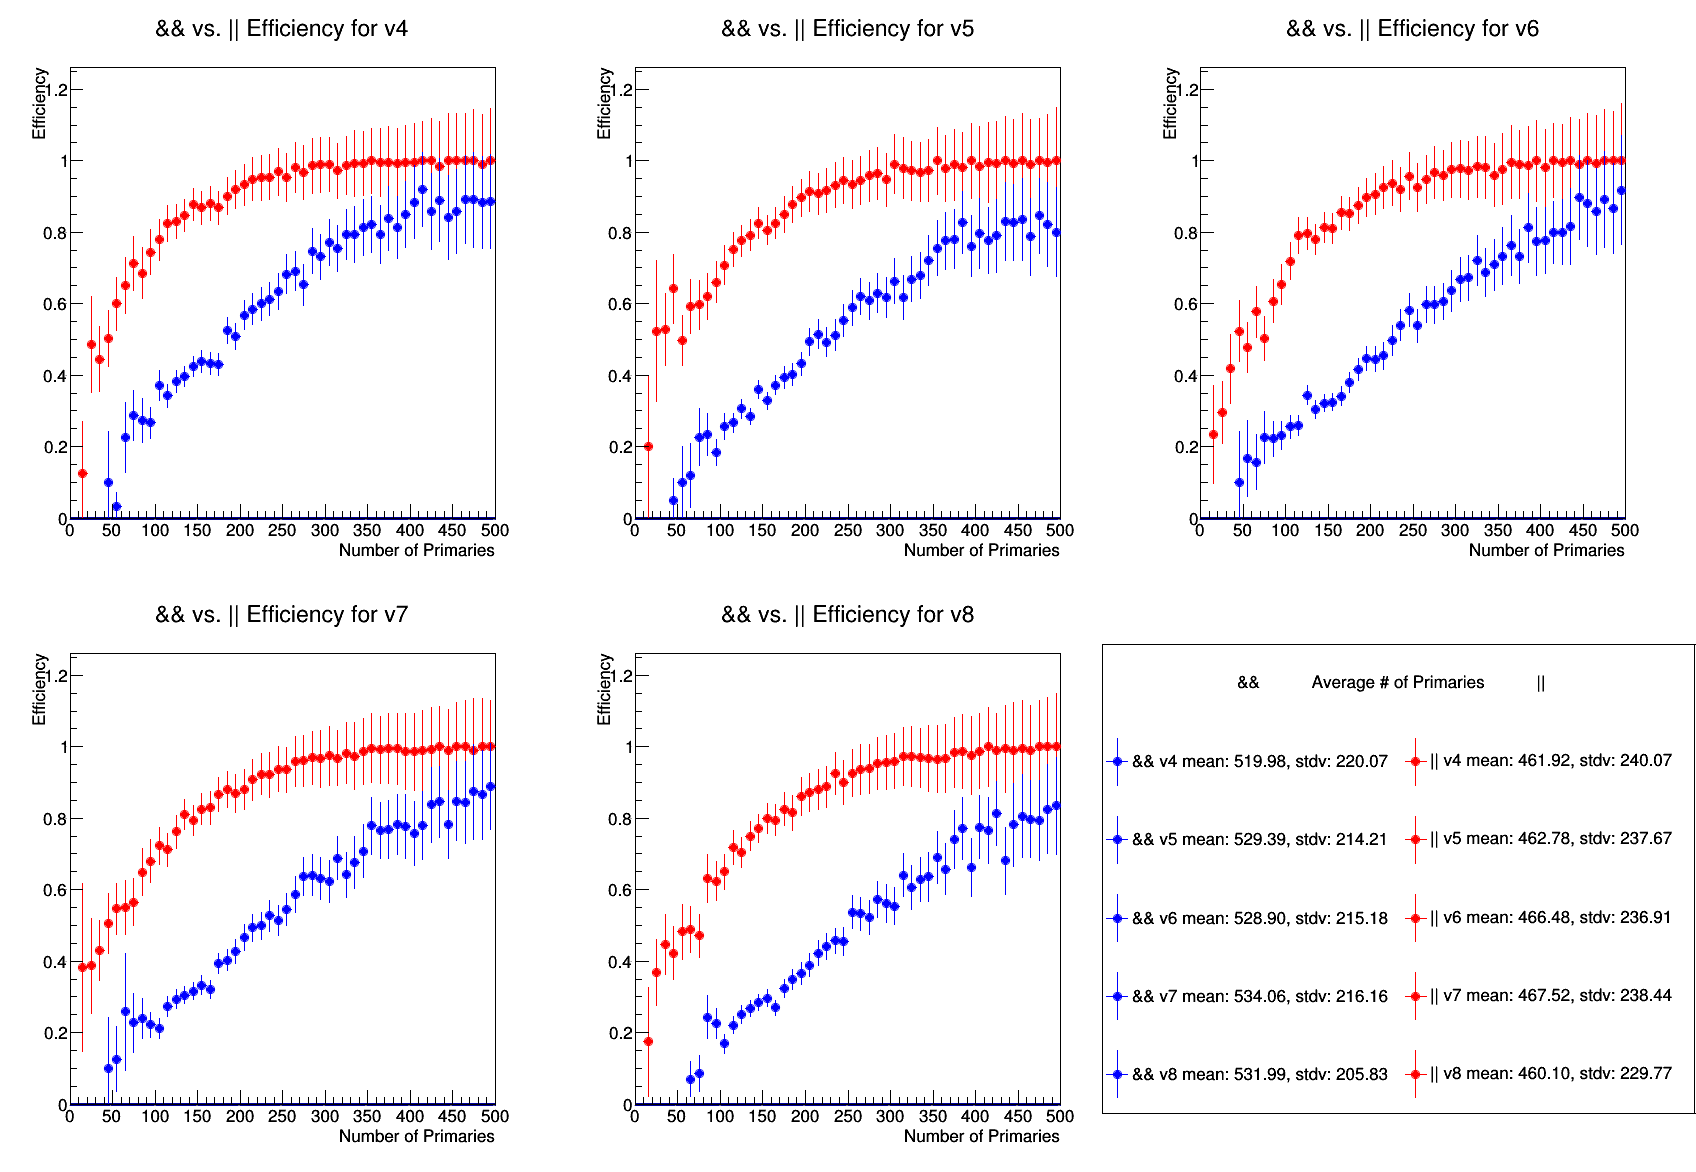

In [54]:
c19= ROOT.TCanvas("c19","c19",1700,1200)
c19.Divide(3,2)

xmin = 0
xmax = 500

efeither = [ effich4e, effich5e, effich6e, effich7e, effich8e]
efand =    [ effich4, effich5, effich6, effich7, effich8]
hs = ['' for _ in range(5)]
for i in range(5):
    p = c19.cd(i+1)
    title = "&& vs. || Efficiency for v" + str(i+4)
    hs[i] = ROOT.THStack("hs" + str(i+4), title)
    efeither[i].SetLineColor(2)
    efeither[i].SetMarkerStyle(8)
    efeither[i].SetMarkerColor(2)
    efand[i].SetLineColor(4)
    efand[i].SetMarkerStyle(8)
    efand[i].SetMarkerColor(4)
    hs[i].Add(efeither[i])
    hs[i].Add(efand[i])
    
    hs[i].Draw("nostack")
    hs[i].GetXaxis().SetTitle("Number of Primaries")
    hs[i].GetYaxis().SetTitle("Efficiency")
    hs[i].GetXaxis().SetRangeUser(xmin,xmax)
    hs[i].GetYaxis().SetRangeUser(0,1.2)

c19.cd(0)
legend = ROOT.TLegend(0.65,0.45,1, 0.05)
legend.SetHeader("                            &&           Average # of Primaries           ||")
legend.SetNColumns(2)
legend.SetMargin(0.10)
legend.SetEntrySeparation(0)
legend.SetColumnSeparation(-.02)
legend.SetTextAlign(12)
legend.AddEntry(efand[0],   "&& v4 mean: %5.2f, stdv: %5.2f" % (effich4.GetMean(1),   effich4.GetStdDev(1)),"lep")
legend.AddEntry(efeither[0],"|| v4 mean: %5.2f, stdv: %5.2f" % (effich4e.GetMean(1), effich4e.GetStdDev(1)),"lep")
legend.AddEntry(efand[1],   "&& v5 mean: %5.2f, stdv: %5.2f" % (effich5.GetMean(1),   effich5.GetStdDev(1)),"lep")
legend.AddEntry(efeither[1],"|| v5 mean: %5.2f, stdv: %5.2f" % (effich5e.GetMean(1), effich5e.GetStdDev(1)),"lep")
legend.AddEntry(efand[2],   "&& v6 mean: %5.2f, stdv: %5.2f" % (effich6.GetMean(1),   effich6.GetStdDev(1)),"lep")
legend.AddEntry(efeither[2],"|| v6 mean: %5.2f, stdv: %5.2f" % (effich6e.GetMean(1), effich6e.GetStdDev(1)),"lep")
legend.AddEntry(efand[3],   "&& v7 mean: %5.2f, stdv: %5.2f" % (effich7.GetMean(1),   effich7.GetStdDev(1)),"lep")
legend.AddEntry(efeither[3],"|| v7 mean: %5.2f, stdv: %5.2f" % (effich7e.GetMean(1), effich7e.GetStdDev(1)),"lep")
legend.AddEntry(efand[4],   "&& v8 mean: %5.2f, stdv: %5.2f" % (effich8.GetMean(1),   effich8.GetStdDev(1)),"lep")
legend.AddEntry(efeither[4],"|| v8 mean: %5.2f, stdv: %5.2f" % (effich8e.GetMean(1), effich8e.GetStdDev(1)),"lep")
legend.Draw()

c19.Draw()

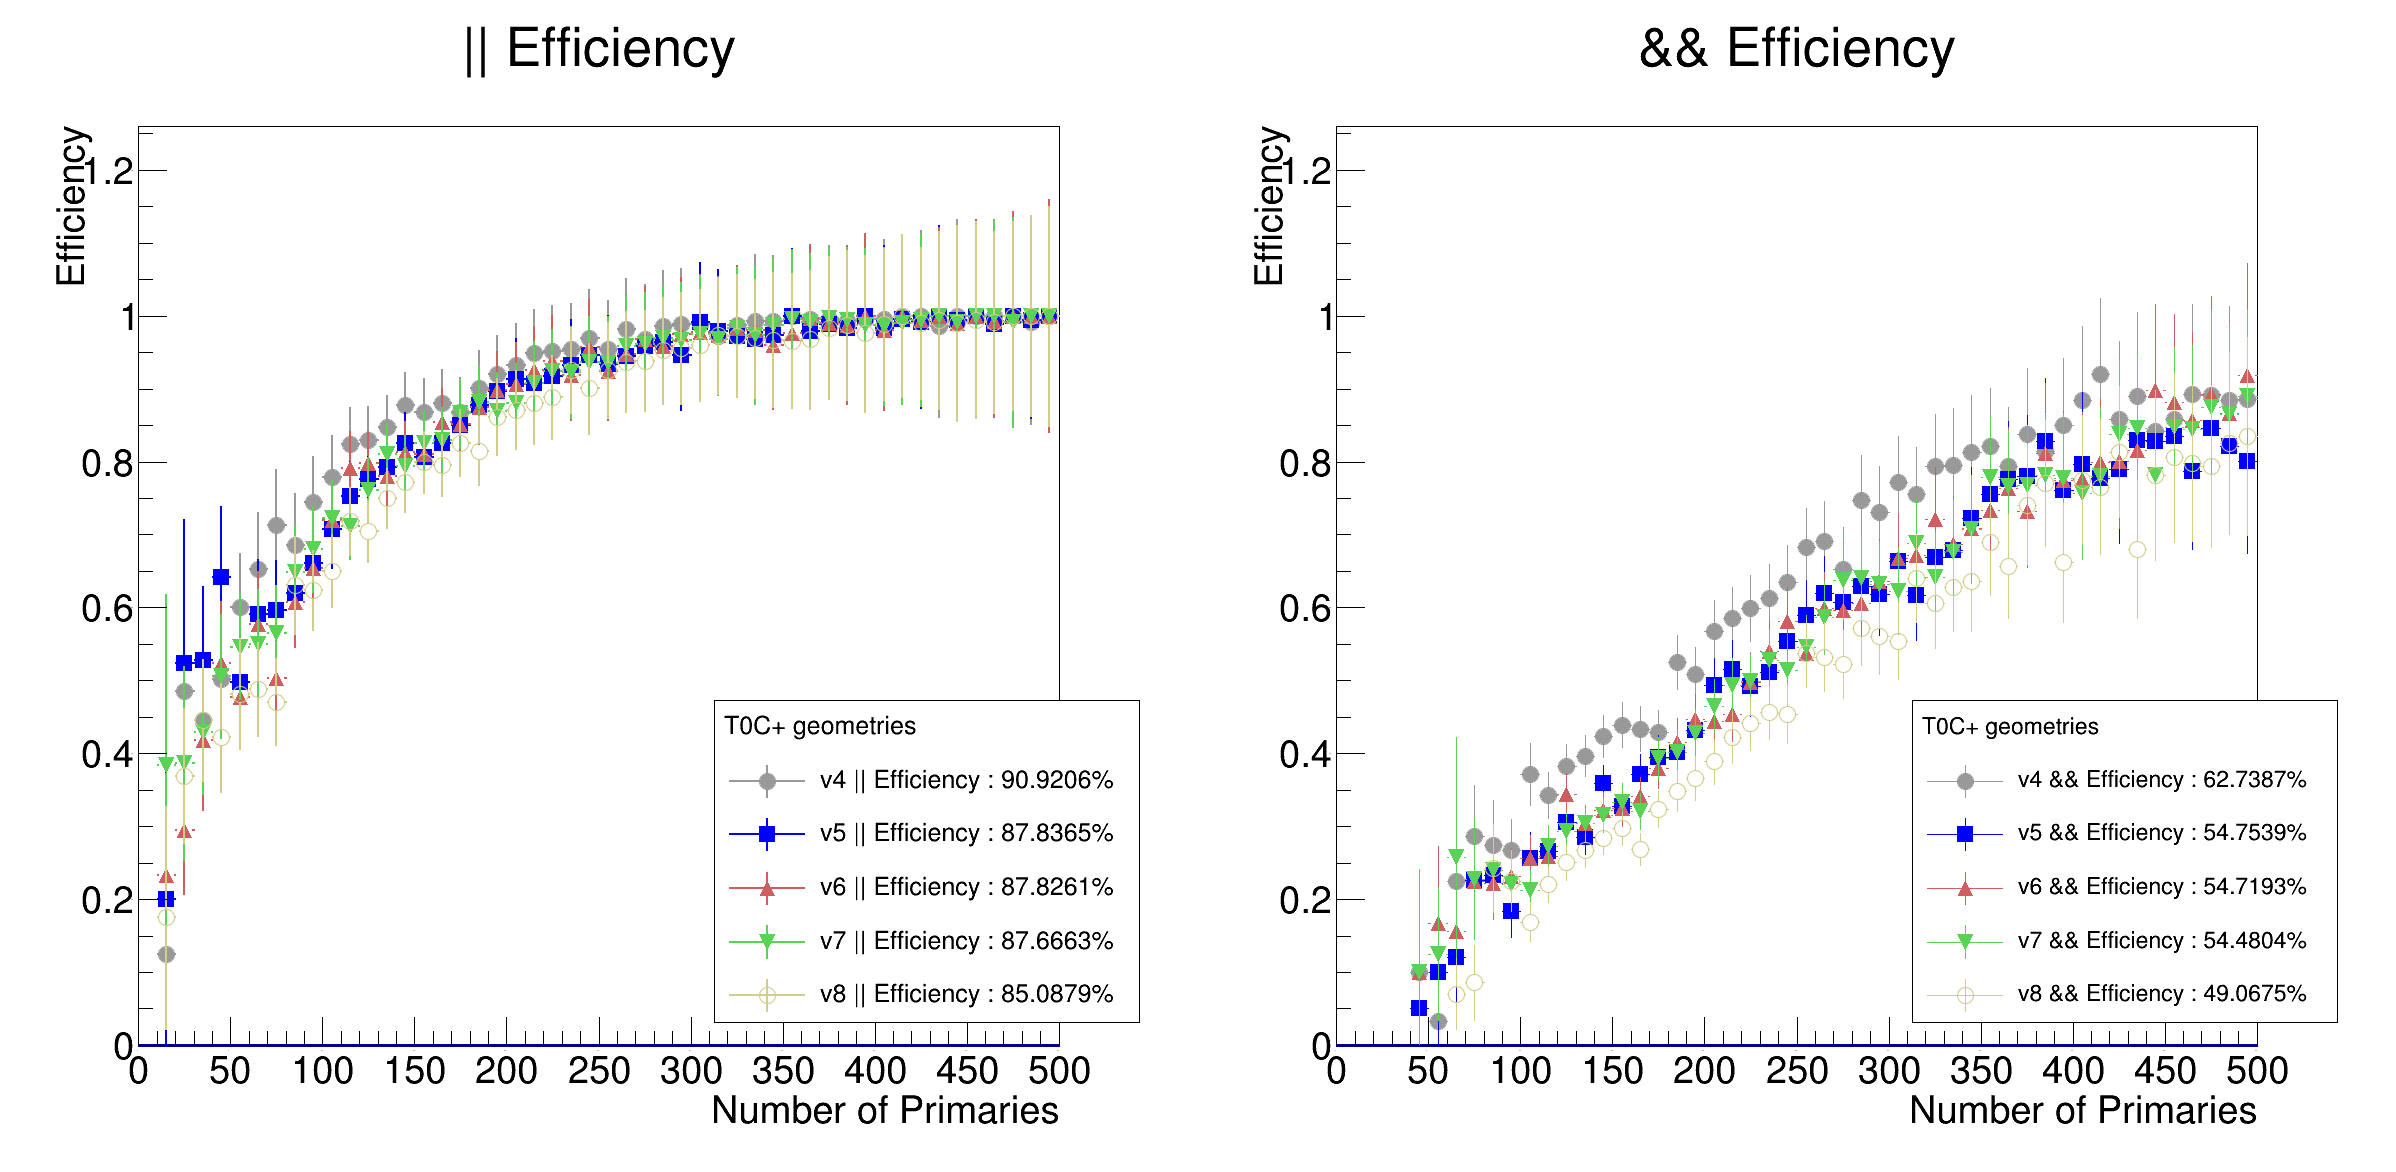

In [55]:
c20= ROOT.TCanvas("c20","c20",2400,1200)
c20.Divide(2,1)

xmin = 0
xmax = 500

#style = ROOT.TStyle()
#style.SetHistLineStyle(2)
#style.SetOptStat(1)

colors = [15, 4, 46, 8, 41]
efeither = [ effich4e, effich5e, effich6e, effich7e, effich8e]
efand =    [ effich4, effich5, effich6, effich7, effich8]
hseither = ROOT.THStack("hseither", "|| Efficiency")
hsand  = ROOT.THStack("hsand", "&& Efficiency")


for i in range(5):
    
    #efeither[i].UseCurrentStyle()
    
    efeither[i].SetLineColorAlpha(colors[i], 1)
    efeither[i].SetLineWidth(2)
    efeither[i].SetMarkerStyle(20 + i)
    efeither[i].SetMarkerSize(2)
    efeither[i].SetMarkerColor(colors[i])
    hseither.Add(efeither[i])
    
    #efand[i].UseCurrentStyle()
    efand[i].SetLineColor(colors[i])
    efand[i].SetMarkerStyle(20 + i)
    efand[i].SetMarkerSize(2)
    efand[i].SetMarkerColor(colors[i])
    hsand.Add(efand[i])
    
p1 = c20.cd(1)
hseither.Draw("nostack")
hseither.GetXaxis().SetRangeUser(xmin, xmax)
hseither.GetXaxis().SetTitle("Number of Primaries")
hseither.GetYaxis().SetTitle("Efficiency")
p2 = c20.cd(2)
hsand.Draw("nostack")
hsand.GetXaxis().SetRangeUser(xmin, xmax)
hsand.GetXaxis().SetTitle("Number of Primaries")
hsand.GetYaxis().SetTitle("Efficiency")

c20.cd(1)
legende = ROOT.TLegend(0.60,0.40,.97, 0.12)
legende.SetHeader("T0C+ geometries")
for i in range(5):
    legende.AddEntry(efeither[i],"v" +str(i+4)+ " || Efficiency : " + str(effics["v" +str(i+4)]['|| Efficiency']) + "%","lep")
legende.Draw()

c20.cd(2)
legenda = ROOT.TLegend(0.60,0.40,.97, 0.12)
legenda.SetHeader("T0C+ geometries")
for i in range(5):
    legenda.AddEntry(efand[i],"v" +str(i+4)+ " && Efficiency : " + str(effics["v" +str(i+4)]['&& Efficiency']) + "%","lep")
legenda.Draw()

c20.Draw()

In [56]:
for i in range(5):
    files[i].close()

A notification cell for when the notebook finishes running all cells. The notebook usually takes about 2 minutes to run. 

In [57]:
%%javascript

alert('Done');

<IPython.core.display.Javascript object>